# Figure showing emergence times of CESM2-CMIP5 Arctic OLR

Are CESM1 and CESM2 physics differing emergence? How are they different?  

__Bootstrap aware comparison.__  

- Mean CESM1-LE  

- Mean CESM2-CMIP5 forcing  

- 10-ensemble member confidence interval from the CESM1-LE  

See Figure 12 - Kay less-melt  


__More extensive code in paper_figures/fig6_OLRemergence_full.ipynb__ I do a comparison between Leroy and Weatherhead there.

Calculate emergence using the Weatherhead-Shaw approach. When letting the forced response evolve (time dependence), emergence differences between the Weatherhead and Leroy estimates of $\tau_{var}$ were minor. We use the Weatherhead method because it also works for short observational periods.

## Load Data

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    np, xr, plt, sns, os, 
    datetime, gridspec, 
    Iterable, cmaps, glob, copy,
    dask, pd, xe
    )

from functions import (
    add_weights,
    to_png, stats, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Methods

#### Weatherhead et al. (1998)

$$ n^* \approx \left[ \frac{3.3 \sigma_{\epsilon}}{|\omega_0|(1-\phi)} \right] ^{2/3} = \left[ \frac{3.3 \sigma_{N}}{|\omega_0|} \sqrt{\frac{1+\phi}{1 - \phi}} \right] ^{2/3}, $$

Reformulation from Phojan et al. (2014):

$$ [\textrm{Var}(\hat{m})]^{1/2} \approx \left[ \frac{12}{T^3} \textrm{Var}(N_t) \tau_{W}  \right]^{1/2}, $$

where $N_t$ is the demeaned and detrended timeseries and $\tau_W$ is the Weatherhead correlation time given by

$$ \tau_W = \frac{1 + \phi}{1 - \phi}. $$

Time-to-emergence $\Delta t$. Emergence has occured if the length of the record exceeds the time-to-emergence.

$$ \Delta t = \left[ \frac{12s^2}{m_{est}^2} \sigma_{var}^2 \tau_{W} \right]^{1/3}, $$

We will use the expression from Phojanamongkolkij (2014) because it is effectively the same as Leroy with a different expression for the correlation time. We take the lag-1 autocorrelation of the noise (taken from the PI-Control simulation), and the measured noise $\sigma_N$ (taken from the PI-Control simulation).

### Load CERES TOA data

To see if observations emerge.

I will interpolate these before calculating timeseries.

__TOA values through 2022/02. (only using 2001-2021)__

In [2]:
ceres_data_dir = '/glade/u/home/jonahshaw/w/obs/CERES/'
ceres_data_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_data_dir)

In [3]:
ceres_toa_ds = xr.open_mfdataset(ceres_data_files)

In [4]:
ceres_asr = ceres_toa_ds['solar_mon'] - ceres_toa_ds['toa_sw_all_mon']
ceres_olr = ceres_toa_ds['toa_lw_all_mon']

In [5]:
# I need a CESM1 file to interpolate to.

cesmle_path = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/'
interp_file = 'FLUT/b.e11.B20TRC5CNBDRD.f09_g16.002.cam.h0.FLUT.192001-200512.nc'

interp_ds = xr.open_dataset('%s/%s' % (cesmle_path,interp_file))
interp_da = interp_ds['FLUT'].isel(time=0)

del interp_ds

In [6]:
regridder = xe.Regridder(ds_in=ceres_asr.isel(time=0),ds_out=interp_da,method='bilinear')

tsel = slice('2001-01-01','2021-12-31')

In [7]:
asr_regrid = regridder(ceres_asr)
olr_regrid = regridder(ceres_olr)

In [8]:
asr_arctic = asr_regrid.sel(lat=slice(70,None))
asr_arctic_wgtd = add_weights(asr_arctic)
asr_tseries = asr_arctic_wgtd.weighted(asr_arctic_wgtd['cell_weight']).mean(dim=['lat','lon']).sel(time=tsel)

In [9]:
olr_arctic = olr_regrid.sel(lat=slice(70,None))
olr_arctic_wgtd = add_weights(olr_arctic)
olr_tseries = olr_arctic_wgtd.weighted(olr_arctic_wgtd['cell_weight']).mean(dim=['lat','lon']).sel(time=tsel)

### Load pre-processed model timeseries

CESM1-LE and CESM2-CMIP5 files

In [10]:
cesm1le_tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM1-LE/ArcticTimeSeries/'
cesm2cmip5_tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM2-CMIP5/ArcticTimeSeries/'

cesm1_pic_ds = xr.open_dataset('%s/CESM1_PIControl_ArcticTimeSeries.nc' % cesm1le_tseries_savedir)
cesm1_ensresponse_ds = xr.open_dataset('%s/CESM1_RCP8.5Members_ArcticTimeSeries.nc' % cesm1le_tseries_savedir)

cesm2cmip5_pic_ds = xr.open_dataset('%s/CESM2_CMIP5_PIControl_ArcticTimeSeries.nc' % cesm2cmip5_tseries_savedir)
cesm2cmip5_ensresponse_ds = xr.open_dataset('%s/CESM2_CMIP5_RCP8.5Members_ArcticTimeSeries.nc' % cesm2cmip5_tseries_savedir)

Load CESM2-CMIP6 1200 year PI-Control simulation (cmorized variables).

In [11]:
cesm2cmip6_tseries_savedir = '/glade/u/home/jonahshaw/w/LENS/CESM2-LE/ArcticTimeSeries/'

cesm2cmip6_pic_ds = xr.open_dataset('%s/CESM2_CMIP6_PIControl_ArcticTimeSeries.nc' % cesm2cmip6_tseries_savedir)

Rename CMIP6-style (cmor) variables to the CESM version.

In [12]:
cmor_rename_dict = {'rlut':'FLUT','rlutcs':'FLUTC','rlus':'FLUS','tas':'TREFHT','ts':'TS',
                    'rsut':'FSUT','rsdt':'FSDT','rsutcs':'FSUTC'}

cesm2cmip6_pic_ds = cesm2cmip6_pic_ds.rename(cmor_rename_dict)
cesm2cmip6_pic_ds
# cesm2cmip5_pic_ds = cesm2cmip5_pic_ds.rename(cmor_rename_dict)
# cesm2cmip5_ensresponse_ds = cesm2cmip5_ensresponse_ds.rename(cmor_rename_dict)

<xarray.Dataset>
Dimensions:  (time: 14400)
Coordinates:
  * time     (time) object 0001-01-01 00:00:00 ... 1200-12-01 00:00:00
Data variables:
    FLUT     (time) float64 ...
    FLUTC    (time) float64 ...
    FLUS     (time) float64 ...
    TS       (time) float64 ...
    TREFHT   (time) float64 ...
    FSUT     (time) float64 ...
    FSDT     (time) float64 ...
    FSUTC    (time) float64 ...
Attributes:
    about:    Arctic (70-90N) timeseries of variables of interest from unforc...

In [13]:
cesm2cmip6_pic_ds['FSNTOA'] = cesm2cmip6_pic_ds['FSDT'] - cesm2cmip6_pic_ds['FSUT']
cesm2cmip6_pic_ds['FSNTOAC'] = cesm2cmip6_pic_ds['FSDT'] - cesm2cmip6_pic_ds['FSUTC']

In [14]:
# emerge_vars = ['FLUT','TS','FLUTC','FLUS']
emerge_vars = ['FSNTOA','FSNTOAC']#,'FSNS','FSNSC'] # <-- cmorized version doesn't have everything


In [15]:
# Calculate surface upwelling radiation.
cesm1_pic_ds['FLUS'] = cesm1_pic_ds['FLDS'] + cesm1_pic_ds['FLNS']
cesm1_ensresponse_ds['FLUS'] = cesm1_ensresponse_ds['FLDS'] + cesm1_ensresponse_ds['FLNS']

cesm2cmip5_pic_ds['FLUS'] = cesm2cmip5_pic_ds['FLDS'] + cesm2cmip5_pic_ds['FLNS']
cesm2cmip5_ensresponse_ds['FLUS'] = cesm2cmip5_ensresponse_ds['FLDS'] + cesm2cmip5_ensresponse_ds['FLNS']

In [16]:
# compute annual averages

cesm1_pic_annavg  = {}
cesm1_lens_annavg = {}

cesm2cmip5_pic_annavg  = {}
cesm2cmip5_lens_annavg = {}

cesm2cmip6_pic_annavg  = {}

for _var in emerge_vars:
    
    # pic_tseries  = cesm1_pic_ds[_var]
    # lens_tseries = cesm1_ensresponse_ds[_var]
    
    cesm1_pic_annavg[_var]  = cesm1_pic_ds[_var].groupby('time.year').mean(dim='time')
    cesm1_lens_annavg[_var] = cesm1_ensresponse_ds[_var].groupby('time.year').mean(dim='time')
    
    cesm2cmip5_pic_annavg[_var]  = cesm2cmip5_pic_ds[_var].groupby('time.year').mean(dim='time')
    cesm2cmip5_lens_annavg[_var] = cesm2cmip5_ensresponse_ds[_var].groupby('time.year').mean(dim='time')
    
    cesm2cmip6_pic_annavg[_var]  = cesm2cmip6_pic_ds[_var].groupby('time.year').mean(dim='time')

cesm1_pic_annavg_ds  = xr.merge(cesm1_pic_annavg.values())
cesm1_lens_annavg_ds = xr.merge(cesm1_lens_annavg.values())
    
cesm2cmip5_pic_annavg_ds  = xr.merge(cesm2cmip5_pic_annavg.values())    
cesm2cmip5_lens_annavg_ds = xr.merge(cesm2cmip5_lens_annavg.values())

cesm2cmip6_pic_annavg_ds  = xr.merge(cesm2cmip6_pic_annavg.values())    

del cesm1_pic_annavg,cesm1_lens_annavg,cesm2cmip5_pic_annavg,cesm2cmip5_lens_annavg

#### 1. Estimate internal variability of the unforced climate from the PI-Control simulation

Use the lag-1 autocorrelation to estimate $\tau_{var}$ per Weatherhead (1998).

In [17]:
# Define a function for standardizing data to be used before calculating an autocorrelation
def standardize(data):
    ''' Standardize the data. '''
    
    if data.std()==0: # edge case that the standard deviation is zero
        data_std = (data - data.mean())
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        return data_std
    else:
        data_std = (data - data.mean()) / data.std()
    
    try:
        np.testing.assert_allclose(data_std.mean(),0,atol=1e-5)
        np.testing.assert_allclose(data_std.std(),1,atol=1e-5)
    except:
        print(data_std[np.isnan(data_std)])
        print(data_std.nanmean())
        print(data_std.nanstd())
        raise AssertionError()
    
    return data_std

In [18]:
# Implementation of Phojanamongkolkij's method:
def calc_tauvar2(autocorr,alpha=0.95):
    '''
    Calculate the autocorrelation time using Leroy (2008), with a selection of significant lags following Phojan.
    Taking sample coefficients at all available lags in estimating Leroy’s uncertainty of the trend will provide zero uncertainty;
    specifically, [the sum of the lagged correlations] is zero. Therefore, it is necessary to set up the criterion to determine which
    sample autocorrelation coefficients to include in the computation. The criterion used in this study is to
    include only the statistically significant [at 95%] coefficients up to 10 log10(T) lags in the summation.
    '''
    
    # the length of the autocorrelation is equal to the length of the timeseries
    N = len(autocorr)
    
    # lags up to "10 log10(T) lags in the summation"
    max_lag = int(10*np.log10(N))
    
    # Select autocorrelation only within a "max lag" of lag-0
    valid_autocorrs = autocorr[N//2-max_lag:N//2+max_lag+1]
    
    # calculate a critical t-statistic
    t_crit = stats.t.ppf((1+alpha)/2,df=N)

    # Calculate the statistical significance bound
    # $$ bound = t_{crit} / \sqrt{N}
    correlation_bound = t_crit / np.sqrt(N)
    
    # check if the autocorrelations are significant
    is_sig_bool = np.abs(valid_autocorrs) > correlation_bound

    # select the significant correlations and sum them to get the correlation time
    tau_var = np.sum(valid_autocorrs[is_sig_bool])
    
    return tau_var

In [19]:
def calc_autocorr(data):
        
    # standardize the data
    data_std = standardize(data) # Standardize the timeseries so the autocorrelation has correct units
    autocorr = np.correlate(data_std,data_std,mode='same') / len(data_std)
    
    return autocorr

def calc_lag1_autocorr(data):
    
    autocorr = calc_autocorr(data)
    
    _lag1_index = len(autocorr) // 2 + 1 # The lag-1 autocorrelation is just off the center of the autocorrelation function, get this index
    _lag1_autocorr = autocorr[_lag1_index] # Get the lag-1 autocorrelation
    
    return xr.DataArray(_lag1_autocorr) # convert back to a dataarray object so xarray can try to concatenate


def calc_tauvar_wrapper2(data):
    """ Wrapper for the Phojanamongkolkij Method"""
    return xr.DataArray(calc_tauvar2(calc_autocorr(data)))

Calculate internal variability characteristics.

#### CESM1-LE

In [20]:
annual_lag1s  = {}
monthly_lag1s = {}

annual_tauvars_W = {}
monthly_tauvars_W = {}

annual_tauvars_LP = {}
monthly_tauvars_LP = {}

annual_stddevs = {}
monthly_stddevs = {}

for _var in emerge_vars:
    
    _pic_tseries  = cesm1_pic_ds[_var]
    # lens_tseries = cesm1_ensresponse_ds[_var]
    
    _pic_annavg  = cesm1_pic_annavg_ds[_var]
    # lens_annavg = lens_tseries.groupby('time.year').mean(dim='time')
    
    # Calculate autocorrelations
    _annual_lag1 = calc_lag1_autocorr(_pic_annavg)
    _annual_lag1.name = _var

    _monthly_lag1 = _pic_tseries.groupby('time.month').map(calc_lag1_autocorr)
    _monthly_lag1.name = _var

    # Translate the lag-1 autocorrelation into a (Weatherhead) Correlation time
    _annual_tauvar_W  = (1 + _annual_lag1) / (1 - _annual_lag1)
    _annual_tauvar_W.name = _var

    _monthly_tauvar_W = (1 + _monthly_lag1) / (1 - _monthly_lag1)
    _monthly_tauvar_W.name = _var
    
    # Calculate correlation times (Leroy + Phojanamongkolkij)
    _annual_tauvar_LP  = calc_tauvar_wrapper2(_pic_annavg)
    _annual_tauvar_LP.name = _var

    _monthly_tauvar_LP = _pic_tseries.groupby('time.month').map(calc_tauvar_wrapper2)
    _monthly_tauvar_LP.name = _var

    # Calculate the standard deviation of internal OLR variability
    _annual_stddev  = _pic_annavg.std()
    _monthly_stddev = _pic_tseries.groupby('time.month').map(xr.DataArray.std)
    
    # Store all
    annual_lag1s[_var]  = _annual_lag1
    monthly_lag1s[_var] = _monthly_lag1
    
    annual_tauvars_W[_var]  = _annual_tauvar_W
    monthly_tauvars_W[_var] = _monthly_tauvar_W
    
    annual_tauvars_LP[_var]  = _annual_tauvar_LP
    monthly_tauvars_LP[_var] = _monthly_tauvar_LP

    annual_stddevs[_var]  = _annual_stddev
    monthly_stddevs[_var] = _monthly_stddev
    

In [21]:
# Convert to xarray.dataset, combine monthly and annual and name with the LE source
cesm1le_annual_lag1s_ds  = xr.merge(annual_lag1s.values())
cesm1le_monthly_lag1s_ds = xr.merge(monthly_lag1s.values())
cesm1le_lag1s_all_ds = xr.merge([cesm1le_monthly_lag1s_ds,cesm1le_annual_lag1s_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

cesm1le_annual_tauvars_W_ds  = xr.merge(annual_tauvars_W.values())
cesm1le_monthly_tauvars_W_ds = xr.merge(monthly_tauvars_W.values())
cesm1le_tauvars_W_all_ds = xr.merge([cesm1le_monthly_tauvars_W_ds,cesm1le_annual_tauvars_W_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

cesm1le_annual_tauvars_LP_ds  = xr.merge(annual_tauvars_LP.values())
cesm1le_monthly_tauvars_LP_ds = xr.merge(monthly_tauvars_LP.values())
cesm1le_tauvars_LP_all_ds = xr.merge([cesm1le_monthly_tauvars_LP_ds,cesm1le_annual_tauvars_LP_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

cesm1le_annual_stddevs_ds  = xr.merge(annual_stddevs.values())
cesm1le_monthly_stddevs_ds = xr.merge(monthly_stddevs.values())
cesm1le_stddevs_all_ds = xr.merge([cesm1le_monthly_stddevs_ds,cesm1le_annual_stddevs_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

# clean up
del (annual_lag1s,
     monthly_lag1s,
      annual_tauvars_W,
     monthly_tauvars_W,
     annual_tauvars_LP,
     monthly_tauvars_LP,
     annual_stddevs,
     monthly_stddevs,
     cesm1le_annual_lag1s_ds,
     cesm1le_monthly_lag1s_ds,
     cesm1le_annual_tauvars_W_ds,
     cesm1le_monthly_tauvars_W_ds,
     cesm1le_annual_tauvars_LP_ds,
     cesm1le_monthly_tauvars_LP_ds,
     cesm1le_annual_stddevs_ds,
     cesm1le_monthly_stddevs_ds
    )

Calculate the uncertainty from 500-year sections of the CESM1 PI-Control simulation to provide confidence intervals to compare CESM2-CMIP5 with.

In [22]:
%%time

startyears = np.arange(0,1302) # this is by index so no offset by 400 years


startyear_lag1s_dict  = {}
startyear_tauvars_LP_dict = {}
startyear_stddevs_dict = {}

for startyear in startyears:
    if startyear % 10 == 0:
        print(startyear,end=' ')
    # subset 500-year segments
    tsel_monthly = cesm1_pic_ds.isel(time=slice(12*startyear,12*(startyear+500)))
    tsel_annual  = cesm1_pic_annavg_ds.isel(year=slice(startyear,startyear+500))
    
    annual_lag1s  = {}
    monthly_lag1s = {}

    annual_tauvars_LP = {}
    monthly_tauvars_LP = {}

    annual_stddevs = {}
    monthly_stddevs = {}

    for _var in emerge_vars:

        _pic_tseries  = tsel_monthly[_var]
        # lens_tseries = cesm1_ensresponse_ds[_var]

        _pic_annavg  = tsel_annual[_var]
        # lens_annavg = lens_tseries.groupby('time.year').mean(dim='time')

        # Calculate autocorrelations
        _annual_lag1 = calc_lag1_autocorr(_pic_annavg)
        _annual_lag1.name = _var

        _monthly_lag1 = _pic_tseries.groupby('time.month').map(calc_lag1_autocorr)
        _monthly_lag1.name = _var

        # Calculate correlation times (Leroy + Phojanamongkolkij)
        _annual_tauvar_LP  = calc_tauvar_wrapper2(_pic_annavg)
        _annual_tauvar_LP.name = _var

        _monthly_tauvar_LP = _pic_tseries.groupby('time.month').map(calc_tauvar_wrapper2)
        _monthly_tauvar_LP.name = _var

        # Calculate the standard deviation of internal OLR variability
        _annual_stddev  = _pic_annavg.std()
        _monthly_stddev = _pic_tseries.groupby('time.month').map(xr.DataArray.std)

        # Store all
        annual_lag1s[_var]  = _annual_lag1
        monthly_lag1s[_var] = _monthly_lag1

        annual_tauvars_LP[_var]  = _annual_tauvar_LP
        monthly_tauvars_LP[_var] = _monthly_tauvar_LP

        annual_stddevs[_var]  = _annual_stddev
        monthly_stddevs[_var] = _monthly_stddev


    # Convert to xarray.dataset, combine monthly and annual and name with the LE source
    _cesm1le_annual_lag1s_ds  = xr.merge(annual_lag1s.values())
    _cesm1le_monthly_lag1s_ds = xr.merge(monthly_lag1s.values())
    _cesm1le_lag1s_all_ds = xr.merge([_cesm1le_monthly_lag1s_ds,_cesm1le_annual_lag1s_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

    _cesm1le_annual_tauvars_LP_ds  = xr.merge(annual_tauvars_LP.values())
    _cesm1le_monthly_tauvars_LP_ds = xr.merge(monthly_tauvars_LP.values())
    _cesm1le_tauvars_LP_all_ds = xr.merge([_cesm1le_monthly_tauvars_LP_ds,_cesm1le_annual_tauvars_LP_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

    _cesm1le_annual_stddevs_ds  = xr.merge(annual_stddevs.values())
    _cesm1le_monthly_stddevs_ds = xr.merge(monthly_stddevs.values())
    _cesm1le_stddevs_all_ds = xr.merge([_cesm1le_monthly_stddevs_ds,_cesm1le_annual_stddevs_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])
    
    # clean up
    # del (annual_lag1s,
    #      monthly_lag1s,
    #      annual_tauvars_LP,
    #      monthly_tauvars_LP,
    #      annual_stddevs,
    #      monthly_stddevs,
    #      _cesm1le_annual_lag1s_ds,
    #      _cesm1le_monthly_lag1s_ds,
    #      _cesm1le_annual_tauvars_LP_ds,
    #      _cesm1le_monthly_tauvars_LP_ds,
    #      _cesm1le_annual_stddevs_ds,
    #      _cesm1le_monthly_stddevs_ds
    #     )
    
    _cesm1le_lag1s_all_ds = _cesm1le_lag1s_all_ds.assign_coords({'startyear':startyear+400}).expand_dims('startyear',axis=-1)    
    _cesm1le_tauvars_LP_all_ds = _cesm1le_tauvars_LP_all_ds.assign_coords({'startyear':startyear+400}).expand_dims('startyear',axis=-1)    
    _cesm1le_stddevs_all_ds = _cesm1le_stddevs_all_ds.assign_coords({'startyear':startyear+400}).expand_dims('startyear',axis=-1)
    
    startyear_lag1s_dict[startyear+400]      = _cesm1le_lag1s_all_ds
    startyear_tauvars_LP_dict[startyear+400] = _cesm1le_tauvars_LP_all_ds
    startyear_stddevs_dict[startyear+400]    = _cesm1le_stddevs_all_ds
    
startyear_lag1s = xr.merge(startyear_lag1s_dict.values())
startyear_tauvars_W = (1 + startyear_lag1s) / (1 - startyear_lag1s)
startyear_tauvars_LP = xr.merge(startyear_tauvars_LP_dict.values())
startyear_stddevs = xr.merge(startyear_stddevs_dict.values())


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 CPU times: user 4min 4s, sys: 247 ms, total: 4min 4s
Wall time: 4min 13s


In [23]:
# startyear_netvar_cesm1le        = startyear_stddevs * startyear_tauvars_LP.map(np.sqrt)
startyear_netvar_cesm1le_LP     = startyear_stddevs * startyear_tauvars_LP.map(np.sqrt)
startyear_netvar_cesm1le_W      = startyear_stddevs * startyear_tauvars_W.map(np.sqrt)

In [24]:
# These functions allow me to calculate a percentile across all variables for each month of the year. 
# Essentially a poorman's version of creating the numpy.percentile function within xarray. But it works!

def xr_percentile_wrapper(nparray,q,axis):
    '''
    Wrapper for a non-xarray function so that it returns a DataArray object.
    I am using nanpercentile here because it handles all cases.
    '''
    return xr.DataArray(np.nanpercentile(nparray,q=q,axis=axis))

def percentile_monthly_wrapper(data,dim,q,axis):
    
    return data.groupby(dim).map(xr_percentile_wrapper,q=q,axis=axis)

In [25]:
'''
In this case, I am mapping across all the variables, 
but also grouping by month and applying the percentile across the "startyear" dimension.
I could also do this more generally with a multidim_groupby_map() call.
'''
startyear_netvar_cesm1le_LP_low  = startyear_netvar_cesm1le_LP.map(percentile_monthly_wrapper,dim='month',q=2.5,axis=0)
startyear_netvar_cesm1le_W_low   = startyear_netvar_cesm1le_W.map(percentile_monthly_wrapper,dim='month',q=2.5,axis=0)

startyear_netvar_cesm1le_LP_high = startyear_netvar_cesm1le_LP.map(percentile_monthly_wrapper,dim='month',q=97.5,axis=0)
startyear_netvar_cesm1le_W_high  = startyear_netvar_cesm1le_W.map(percentile_monthly_wrapper,dim='month',q=97.5,axis=0)

startyear_netvar_cesm1le_LP_mid  = startyear_netvar_cesm1le_LP.map(percentile_monthly_wrapper,dim='month',q=50,axis=0)
startyear_netvar_cesm1le_W_mid   = startyear_netvar_cesm1le_W.map(percentile_monthly_wrapper,dim='month',q=50,axis=0)

#### CESM2-CMIP5

In [26]:
annual_lag1s  = {}
monthly_lag1s = {}

annual_tauvars_LP = {}
monthly_tauvars_LP = {}

annual_stddevs = {}
monthly_stddevs = {}

for _var in emerge_vars:
    
    _pic_tseries  = cesm2cmip5_pic_ds[_var]
    # lens_tseries = cesm1_ensresponse_ds[_var]
    
    _pic_annavg  = cesm2cmip5_pic_annavg_ds[_var]
    # lens_annavg = lens_tseries.groupby('time.year').mean(dim='time')
    
    # Calculate autocorrelations
    _annual_lag1 = calc_lag1_autocorr(_pic_annavg)
    _annual_lag1.name = _var

    _monthly_lag1 = _pic_tseries.groupby('time.month').map(calc_lag1_autocorr)
    _monthly_lag1.name = _var

    # Calculate correlation times (Leroy + Phojanamongkolkij)
    _annual_tauvar_LP  = calc_tauvar_wrapper2(_pic_annavg)
    _annual_tauvar_LP.name = _var

    _monthly_tauvar_LP = _pic_tseries.groupby('time.month').map(calc_tauvar_wrapper2)
    _monthly_tauvar_LP.name = _var

    # Calculate the standard deviation of internal OLR variability
    _annual_stddev  = _pic_annavg.std()
    _monthly_stddev = _pic_tseries.groupby('time.month').map(xr.DataArray.std)
    
    # Store all
    annual_lag1s[_var]  = _annual_lag1
    monthly_lag1s[_var] = _monthly_lag1
    
    annual_tauvars_LP[_var]  = _annual_tauvar_LP
    monthly_tauvars_LP[_var] = _monthly_tauvar_LP

    annual_stddevs[_var]  = _annual_stddev
    monthly_stddevs[_var] = _monthly_stddev
    

In [27]:
# Convert to xarray.dataset, combine monthly and annual and name with the LE source
cesm2_cmip5_annual_lag1s_ds  = xr.merge(annual_lag1s.values())
cesm2_cmip5_monthly_lag1s_ds = xr.merge(monthly_lag1s.values())
cesm2_cmip5_lag1s_all_ds = xr.merge([cesm2_cmip5_monthly_lag1s_ds,cesm2_cmip5_annual_lag1s_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])
cesm2_cmip5_tauvars_W_all_ds = (1 + cesm2_cmip5_lag1s_all_ds) / (1 - cesm2_cmip5_lag1s_all_ds)

cesm2_cmip5_annual_tauvars_LP_ds  = xr.merge(annual_tauvars_LP.values())
cesm2_cmip5_monthly_tauvars_LP_ds = xr.merge(monthly_tauvars_LP.values())
cesm2_cmip5_tauvars_LP_all_ds = xr.merge([cesm2_cmip5_monthly_tauvars_LP_ds,cesm2_cmip5_annual_tauvars_LP_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

cesm2_cmip5_annual_stddevs_ds  = xr.merge(annual_stddevs.values())
cesm2_cmip5_monthly_stddevs_ds = xr.merge(monthly_stddevs.values())
cesm2_cmip5_stddevs_all_ds = xr.merge([cesm2_cmip5_monthly_stddevs_ds,cesm2_cmip5_annual_stddevs_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

# clean up
del (annual_lag1s,
     monthly_lag1s,
     annual_tauvars_LP,
     monthly_tauvars_LP,
     annual_stddevs,
     monthly_stddevs,
     cesm2_cmip5_annual_lag1s_ds,
     cesm2_cmip5_monthly_lag1s_ds,
     cesm2_cmip5_annual_tauvars_LP_ds,
     cesm2_cmip5_monthly_tauvars_LP_ds,
     cesm2_cmip5_annual_stddevs_ds,
     cesm2_cmip5_monthly_stddevs_ds
    )

#### CESM2-CMIP6

In [28]:
annual_lag1s  = {}
monthly_lag1s = {}

annual_tauvars_LP = {}
monthly_tauvars_LP = {}

annual_stddevs = {}
monthly_stddevs = {}

for _var in emerge_vars:
    
    _pic_tseries  = cesm2cmip6_pic_ds[_var]
    # lens_tseries = cesm1_ensresponse_ds[_var]
    
    _pic_annavg  = cesm2cmip6_pic_annavg_ds[_var]
    # lens_annavg = lens_tseries.groupby('time.year').mean(dim='time')
    
    # Calculate autocorrelations
    _annual_lag1 = calc_lag1_autocorr(_pic_annavg)
    _annual_lag1.name = _var

    _monthly_lag1 = _pic_tseries.groupby('time.month').map(calc_lag1_autocorr)
    _monthly_lag1.name = _var

    # Calculate correlation times (Leroy + Phojanamongkolkij)
    _annual_tauvar_LP  = calc_tauvar_wrapper2(_pic_annavg)
    _annual_tauvar_LP.name = _var

    _monthly_tauvar_LP = _pic_tseries.groupby('time.month').map(calc_tauvar_wrapper2)
    _monthly_tauvar_LP.name = _var

    # Calculate the standard deviation of internal OLR variability
    _annual_stddev  = _pic_annavg.std()
    _monthly_stddev = _pic_tseries.groupby('time.month').map(xr.DataArray.std)
    
    # Store all
    annual_lag1s[_var]  = _annual_lag1
    monthly_lag1s[_var] = _monthly_lag1
    
    annual_tauvars_LP[_var]  = _annual_tauvar_LP
    monthly_tauvars_LP[_var] = _monthly_tauvar_LP

    annual_stddevs[_var]  = _annual_stddev
    monthly_stddevs[_var] = _monthly_stddev
    

In [29]:
# Convert to xarray.dataset, combine monthly and annual and name with the LE source
cesm2_cmip6_annual_lag1s_ds  = xr.merge(annual_lag1s.values())
cesm2_cmip6_monthly_lag1s_ds = xr.merge(monthly_lag1s.values())
cesm2_cmip6_lag1s_all_ds = xr.merge([cesm2_cmip6_monthly_lag1s_ds,cesm2_cmip6_annual_lag1s_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])
cesm2_cmip6_tauvars_W_all_ds = (1 + cesm2_cmip6_lag1s_all_ds) / (1 - cesm2_cmip6_lag1s_all_ds)

cesm2_cmip6_annual_tauvars_LP_ds  = xr.merge(annual_tauvars_LP.values())
cesm2_cmip6_monthly_tauvars_LP_ds = xr.merge(monthly_tauvars_LP.values())
cesm2_cmip6_tauvars_LP_all_ds = xr.merge([cesm2_cmip6_monthly_tauvars_LP_ds,cesm2_cmip6_annual_tauvars_LP_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

cesm2_cmip6_annual_stddevs_ds  = xr.merge(annual_stddevs.values())
cesm2_cmip6_monthly_stddevs_ds = xr.merge(monthly_stddevs.values())
cesm2_cmip6_stddevs_all_ds = xr.merge([cesm2_cmip6_monthly_stddevs_ds,cesm2_cmip6_annual_stddevs_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

# clean up
del (annual_lag1s,
     monthly_lag1s,
     annual_tauvars_LP,
     monthly_tauvars_LP,
     annual_stddevs,
     monthly_stddevs,
     cesm2_cmip6_annual_lag1s_ds,
     cesm2_cmip6_monthly_lag1s_ds,
     cesm2_cmip6_annual_tauvars_LP_ds,
     cesm2_cmip6_monthly_tauvars_LP_ds,
     cesm2_cmip6_annual_stddevs_ds,
     cesm2_cmip6_monthly_stddevs_ds
    )

#### 2. Calculate a regressed trend for each ensemble member at each additional timestep

Functions.

In [30]:
def linear_polyfit(ds,dim='time.year'):
    '''
    Simple wrapped for xarray's polyfit function because I couldn't figure out how to pass arguments...
    allens_all_tseries_preproc.groupby('time.month').map(xr.Dataset.polyfit,args=('time',1)) # this should work if you use xr.DataArray?
    '''
    # ds['time'] = ds[dim] # reassign the time coordinate so that the polyfit gets units right
    ds['time'] = ds['time.year'] # reassign the time coordinate so that the polyfit gets units right, this is the old code
    
    return ds.polyfit(dim='time',deg=1)

def calc_slopes_by_dur(data,ann_tsel,durations,calc_detrended=False):
    '''Wrapper for calculating slopes for different durations'''
    
    if type(data) == xr.core.dataset.Dataset:
        return __calc_slopes_by_dur_DATASET(data,ann_tsel,durations,calc_detrended=calc_detrended)
    elif type(data) == xr.core.dataarray.DataArray:
        return __calc_slopes_by_dur_DATAARRAY(data,ann_tsel,durations,calc_detrended=calc_detrended)
    else:
        print('First argument must be a xr.core.dataset.Dataset or xr.core.dataarray.DataArray object.')
        return None

        
def __calc_slopes_by_dur_DATASET(data,ann_tsel,durations,calc_detrended=False):
    
    annavg_slopes_dict  = {}
    monthly_slopes_dict = {}

    if calc_detrended:
        annavg_detrend_dict  = {}
        monthly_detrend_dict = {}
            
    for _var in data.data_vars:    
        ens_tseries = data[_var] # select your variable

        # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
        ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
        ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)

        lens_slopes_dict = {}
        lens_slopes_monthly_dict = {}
        
        if calc_detrended:
            lens_detrend_dict = {}
            lens_detrend_monthly_dict = {}
        
        for _dur in durations: # iterate over possible detection durations 
            tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
            tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

            _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
            _lens_slopes = _lens_polyfit['polyfit_coefficients'] # pull out the slope from the linear fit

            _lens_polyfit_monthly = tseries_dur_monthly_subset.groupby('time.month').map(linear_polyfit)
            _lens_slopes_monthly  = _lens_polyfit_monthly['polyfit_coefficients']

            # Add a 'duration' coordinate
            _lens_slopes = _lens_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            _lens_slopes_monthly = _lens_slopes_monthly.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
            
            lens_slopes_dict[_dur] = _lens_slopes # save slopes in an inner dictionary
            lens_slopes_monthly_dict[_dur] = _lens_slopes_monthly
                        
            ###### Calculate detrended data
            if calc_detrended:
                _linear_tseries_ann     = _lens_slopes.sel(degree=1)*tseries_dur_subset['year'] + _lens_slopes.sel(degree=0)
            
                _detrended_tseries_ann     = _linear_tseries_ann - tseries_dur_subset.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)            
                _detrended_tseries_monthly = tseries_dur_monthly_subset.groupby('time.month').map(monthly_detrend_helper,coeffs=_lens_slopes_monthly)

                _detrended_tseries_ann.name = _var
                _detrended_tseries_monthly.name = _var

                lens_detrend_dict[_dur]         = _detrended_tseries_ann
                lens_detrend_monthly_dict[_dur] = _detrended_tseries_monthly
        
        # combine the data along the new 'duration' dimension
        # try:
        #     _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']
        # except:
        #     _temp_slopes_da = xr.concat(list(lens_slopes_dict.values()),dim='duration')
        _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']    
        _temp_slopes_da.name = _var
        
        # try:
        #     _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
        # except:
        #     _temp_slopes_monthly_da = xr.concat(list(lens_slopes_monthly_dict.values()),dim='duration')
        _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
        _temp_slopes_monthly_da.name = data.name

        annavg_slopes_dict[_var] = _temp_slopes_da
        monthly_slopes_dict[_var] = _temp_slopes_monthly_da
        
        del lens_slopes_dict,lens_slopes_monthly_dict
        
        if calc_detrended:
            _temp_detrend_da = xr.merge(list(lens_detrend_dict.values()))
            _temp_detrend_monthly_da = xr.merge(list(lens_detrend_monthly_dict.values()))
            
            annavg_detrend_dict[_var]  = _temp_detrend_da
            monthly_detrend_dict[_var] = _temp_detrend_monthly_da
            
            del lens_detrend_dict,lens_detrend_monthly_dict

    data_slopes_dur_ds = xr.merge(annavg_slopes_dict.values()).sel(degree=1).drop('degree')
    data_slopes_monthly_dur_ds = xr.merge(monthly_slopes_dict.values()).sel(degree=1).drop('degree')
        
    if calc_detrended:
        data_detrend_dur_ds = xr.merge(annavg_detrend_dict.values())
        data_detrend_monthly_dur_ds = xr.merge(monthly_detrend_dict.values())

        del annavg_slopes_dict,monthly_slopes_dict,annavg_detrend_dict,monthly_detrend_dict
        return data_slopes_dur_ds,data_slopes_monthly_dur_ds,data_detrend_dur_ds,data_detrend_monthly_dur_ds
        
    else:
        del annavg_slopes_dict,monthly_slopes_dict
        return data_slopes_dur_ds,data_slopes_monthly_dur_ds

### Doesn't work but maybe one day will!
# def __calc_slopes_by_dur_DATASET(data,ann_tsel,durations,calc_detrended=True):
#     return data.map(__calc_slopes_by_dur_DATAARRAY,ann_tsel=ann_tsel,durations=durations,calc_detrended=calc_detrended)
    
def __calc_slopes_by_dur_DATAARRAY(data,ann_tsel,durations,calc_detrended=False):
    
    ens_tseries = data # select your variable
    
    # turn into annual tseries, need to sub-select by year because we don't have a full year at the beginning or end of the timeseries
    ens_tseries_ann = ens_tseries.sel(time=ann_tsel).groupby('time.year').mean('time')
    ens_tseries_monthly = ens_tseries.sel(time=ann_tsel)
    
    lens_slopes_dict = {}
    lens_slopes_monthly_dict = {}
    
    if calc_detrended:
        lens_detrend_dict = {}
        lens_detrend_monthly_dict = {}
        
    for _dur in durations: # iterate over possible detection durations 
        tseries_dur_subset = ens_tseries_ann.isel(year=slice(None,_dur)) # subset the annual resolution data in time
        tseries_dur_monthly_subset = ens_tseries_monthly.isel(time=slice(None,12*_dur)) # subset the monthly resolution data in time

        _lens_polyfit = tseries_dur_subset.polyfit(dim='year',deg=1) # take a linear fit
        _lens_slopes = _lens_polyfit['polyfit_coefficients'].compute() # pull out the slope from the linear fit

        _lens_polyfit_monthly = tseries_dur_monthly_subset.groupby('time.month').map(linear_polyfit)
        _lens_slopes_monthly  = _lens_polyfit_monthly['polyfit_coefficients'].compute()

        # Add a 'duration' coordinate
        _lens_slopes = _lens_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
        _lens_slopes_monthly = _lens_slopes_monthly.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)

        # save slopes in an inner dictionary
        lens_slopes_dict[_dur] = _lens_slopes.sel(degree=1).drop('degree')#.compute()
        lens_slopes_monthly_dict[_dur] = _lens_slopes_monthly.sel(degree=1).drop('degree')#.compute()
        
        ###### Calculate detrended data
        if calc_detrended:
            _linear_tseries_ann     = _lens_slopes.sel(degree=1)*tseries_dur_subset['year'] + _lens_slopes.sel(degree=0)
            
            _detrended_tseries_ann     = _linear_tseries_ann - tseries_dur_subset.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)            
            _detrended_tseries_monthly = tseries_dur_monthly_subset.groupby('time.month').map(monthly_detrend_helper,coeffs=_lens_slopes_monthly)
                        
            _detrended_tseries_ann.name = data.name
            _detrended_tseries_monthly.name = data.name
            
            lens_detrend_dict[_dur]         = _detrended_tseries_ann
            lens_detrend_monthly_dict[_dur] = _detrended_tseries_monthly

    # combine the data along the new 'duration' dimension
    # errors here with lower dimensional data, move the drop degree step earlier
    _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']
    # try:
    #     _temp_slopes_da = xr.merge(list(lens_slopes_dict.values()))['polyfit_coefficients']
    # except:
    #     return lens_slopes_dict
    #     _temp_slopes_da = xr.concat(list(lens_slopes_dict.values()),dim='duration')
    _temp_slopes_da.name = data.name

    _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
    # try:
    #     _temp_slopes_monthly_da = xr.merge(list(lens_slopes_monthly_dict.values()))['polyfit_coefficients']
    # except:
    #     _temp_slopes_monthly_da = xr.concat(list(lens_slopes_monthly_dict.values()),dim='duration')
    _temp_slopes_monthly_da.name = data.name

    _temp_slopes_da = _temp_slopes_da#.sel(degree=1).drop('degree')
    _temp_slopes_monthly_da = _temp_slopes_monthly_da#.sel(degree=1).drop('degree')

    if calc_detrended:
        _temp_detrend_da = xr.merge(list(lens_detrend_dict.values()))
        _temp_detrend_monthly_da = xr.merge(list(lens_detrend_monthly_dict.values()))

        del lens_slopes_dict,lens_slopes_monthly_dict,lens_detrend_dict,lens_detrend_monthly_dict
        return _temp_slopes_da,_temp_slopes_monthly_da,_temp_detrend_da,_temp_detrend_monthly_da

    else:
        del lens_slopes_dict,lens_slopes_monthly_dict
        return _temp_slopes_da,_temp_slopes_monthly_da    

def monthly_detrend_helper(tseries,coeffs=None):
    '''
    Helper function (poorly coded) to detrend monthly timeseries if given the linear fit coefficients.
    '''

    month = tseries[0]['time.month']
    years = tseries['time.year']

    coeff0 = coeffs.sel(month=month,degree=0)
    coeff1 = coeffs.sel(month=month,degree=1)

    proxy_tseries = coeff1*years + coeff0 # y = mx+b

    _detrended_tseries_monthly = proxy_tseries - tseries
    _detrended_tseries_monthly = _detrended_tseries_monthly.groupby('time.year').mean('time') # shift from the full 'time' coordinate to a 'year' coordinate

    return _detrended_tseries_monthly

In [31]:
durations = np.arange(2,80)

Calculate slopes for the model data

#### CESM1-LE

In [32]:
%%time

cesm1le_slopes_annual  = {}
cesm1le_slopes_monthly = {}

for _var in emerge_vars:
    _slopes_ann,_slopes_monthly = calc_slopes_by_dur(cesm1_ensresponse_ds[_var],ann_tsel=slice('2001-01-01',None),durations=durations)
    
    cesm1le_slopes_annual[_var]  = _slopes_ann
    cesm1le_slopes_monthly[_var] = _slopes_monthly

CPU times: user 7.83 s, sys: 81.8 ms, total: 7.92 s
Wall time: 8.12 s


In [33]:
cesm1le_slopes_annual_ds  = xr.merge(list(cesm1le_slopes_annual.values()))
cesm1le_slopes_monthly_ds = xr.merge(list(cesm1le_slopes_monthly.values()))

cesm1le_slopes_all_ds = xr.merge([cesm1le_slopes_monthly_ds,cesm1le_slopes_annual_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

#### CESM2-CMIP5

In [34]:
%%time

cesm2_cmip5_slopes_annual  = {}
cesm2_cmip5_slopes_monthly = {}

for _var in emerge_vars:
    _slopes_ann,_slopes_monthly = calc_slopes_by_dur(cesm2cmip5_ensresponse_ds[_var],ann_tsel=slice('2001-01-01',None),durations=durations)
    
    cesm2_cmip5_slopes_annual[_var]  = _slopes_ann
    cesm2_cmip5_slopes_monthly[_var] = _slopes_monthly

CPU times: user 7.89 s, sys: 53.9 ms, total: 7.94 s
Wall time: 8.14 s


In [35]:
cesm2_cmip5_slopes_annual_ds  = xr.merge(list(cesm2_cmip5_slopes_annual.values()))
cesm2_cmip5_slopes_monthly_ds = xr.merge(list(cesm2_cmip5_slopes_monthly.values()))

cesm2_cmip5_slopes_all_ds = xr.merge([cesm2_cmip5_slopes_monthly_ds,cesm2_cmip5_slopes_annual_ds.assign_coords({'month':13}).expand_dims('month',axis=-1)])

Calculate slopes for the observational data (manually because my code is messing up for some reason...

In [37]:
monthly_asr_slopes = []
annual_asr_slopes  = []

asr_tseries_ann = asr_tseries.groupby('time.year').mean(dim='time')

for _dur in np.arange(3,22):
    
    monthly_tsubset = asr_tseries.isel(time=slice(None,12*_dur))
    annual_tsubset  = asr_tseries_ann.isel(year=slice(None,_dur))
    
    monthly_polyfit = monthly_tsubset.groupby('time.month').map(linear_polyfit)
    annual_polyfit  = annual_tsubset.polyfit(dim='year',deg=1)
    
    monthly_slopes  = monthly_polyfit['polyfit_coefficients'].sel(degree=1).drop('degree')
    annual_slopes   = annual_polyfit['polyfit_coefficients'].sel(degree=1).drop('degree')
    
    monthly_slopes_out = monthly_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
    annual_slopes_out  = annual_slopes.assign_coords({'duration':_dur}).expand_dims('duration',axis=-1)
    
    monthly_asr_slopes.append(monthly_slopes_out)
    annual_asr_slopes.append(annual_slopes_out)

monthly_asr_slopes_da = xr.concat(monthly_asr_slopes,dim='duration').compute()
annual_asr_slopes_da  = xr.concat(annual_asr_slopes,dim='duration').compute()

all_asr_slopes_ceres_ds = xr.merge([monthly_asr_slopes_da,annual_asr_slopes_da.assign_coords({'month':13}).expand_dims('month',axis=-1)])

#### 3. Use the Weatherhead/Leroy/Phojanamongkolkij approach to calculate time-to-emergence for each ensemble member

Emergence occurs when the climate signal exits internal variability for the LAST time.

Calculate predicted time-to-emergence 

#### CESM1-LE and CESM2-CMIP5 emergence

In [38]:
# Use the power of xarray to calculate emergence for all variables and months in a single line!!
s = 2

cesm1le_TTE_all_LP = (12*s**2 * cesm1le_stddevs_all_ds**2 * cesm1le_tauvars_LP_all_ds / cesm1le_slopes_all_ds**2)**(1/3)
cesm1le_TTE_all_W  = (12*s**2 * cesm1le_stddevs_all_ds**2 * cesm1le_tauvars_W_all_ds / cesm1le_slopes_all_ds**2)**(1/3)

cesm2cmip5_TTE_all_LP = (12*s**2 * cesm2_cmip5_stddevs_all_ds**2 * cesm2_cmip5_tauvars_LP_all_ds / cesm2_cmip5_slopes_all_ds**2)**(1/3)
cesm2cmip5_TTE_all_W = (12*s**2 * cesm2_cmip5_stddevs_all_ds**2 * cesm2_cmip5_tauvars_W_all_ds / cesm2_cmip5_slopes_all_ds**2)**(1/3)

#### CERES observations with CESM1-LE pre-industrial variability

In [39]:
asr_all_stddevs  = cesm1le_stddevs_all_ds['FSNTOA']
asr_all_tauvars_LP  = cesm1le_tauvars_LP_all_ds['FSNTOA']

s = 2

ceresasr_TTE_all_LP  = ((12*s**2 * asr_all_stddevs**2 * asr_all_tauvars_LP / all_asr_slopes_ceres_ds**2)**(1/3))['polyfit_coefficients']

October is super close to emergence if we ignore observational uncertainty.

In [40]:
asr_all_stddevs  = cesm1le_stddevs_all_ds['FSNTOA']
asr_all_tauvars_W  = cesm1le_tauvars_W_all_ds['FSNTOA']

s = 2

ceresasr_TTE_all_W  = ((12*s**2 * asr_all_stddevs**2 * asr_all_tauvars_W / all_asr_slopes_ceres_ds**2)**(1/3))['polyfit_coefficients']

__Translate to an emergence time (when the signal exits internal variability for the last time).__

In [41]:
def emergence_wrapper(TTE_data):
    detect_ds = TTE_data < TTE_data.duration
    duration_broad = detect_ds.duration.broadcast_like(detect_ds)
    
    emergence_ds = 1 + duration_broad.where(~detect_ds).max(dim='duration')
    
    return emergence_ds

In [42]:
ceresasr_emergence_LP = emergence_wrapper(ceresasr_TTE_all_LP)
ceresasr_emergence_W = emergence_wrapper(ceresasr_TTE_all_W)

In [43]:
print(ceresasr_emergence_LP)

print(ceresasr_emergence_W)

<xarray.DataArray 'duration' (month: 13)>
array([nan, 22., 22., 22., 21., 19., 22., 22., 22., 22., 22., 22., 22.])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
<xarray.DataArray 'duration' (month: 13)>
array([nan, 22., 22., 22., 20.,  7., 22., 22., 22., 18., 22., 22., 22.])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12 13


__According to the Leroy metric nothing has emerged. According to the better Weatherhead metric, only October has emerged and did so in 2019.__

In [44]:
cesm1le_emergence_LP = emergence_wrapper(cesm1le_TTE_all_LP)
cesm2cmip5_emergence_LP = emergence_wrapper(cesm2cmip5_TTE_all_LP)

In [45]:
cesm1le_emergence_W = emergence_wrapper(cesm1le_TTE_all_W)
cesm2cmip5_emergence_W = emergence_wrapper(cesm2cmip5_TTE_all_W)

Get trends at the time of mean emergence for "variability_comparison.ipynb".

CESM1-LE

In [46]:
cesm1le_trends_at_emerge = []

for month_emerge,month_trends in zip(cesm1le_emergence_LP['FSNTOA'].mean(dim='ens'),cesm1le_slopes_monthly['FSNTOA'].mean(dim='ens')):
    # print(month_emerge)
    
    emerge_trend =  month_trends.sel(duration=month_emerge,method='nearest')
    cesm1le_trends_at_emerge.append(emerge_trend)
    
    # break
cesm1le_trends_at_emerge = np.array(cesm1le_trends_at_emerge)

In [47]:
cesm1le_trends_at_emerge

array([5.14837899e-05, 5.53229634e-03, 3.80089336e-02, 1.06178292e-01,
       1.98975082e-01, 4.87582288e-01, 7.38546834e-01, 5.22917970e-01,
       2.35976577e-01, 4.49817575e-02, 1.00765017e-03, 0.00000000e+00])

CESM2-CMIP5

In [48]:
cesm2cmip5_trends_at_emerge = []

for month_emerge,month_trends in zip(cesm2cmip5_emergence_LP['FSNTOA'].mean(dim='ens'),cesm2_cmip5_slopes_monthly['FSNTOA'].mean(dim='ens')):
    # print(month_emerge)
    
    emerge_trend =  month_trends.sel(duration=month_emerge,method='nearest')
    cesm2cmip5_trends_at_emerge.append(emerge_trend)
    
    # break
cesm2cmip5_trends_at_emerge = np.array(cesm2cmip5_trends_at_emerge)

In [49]:
cesm2cmip5_trends_at_emerge

array([7.14751277e-05, 7.62358423e-03, 4.63972461e-02, 1.09213035e-01,
       1.91728663e-01, 3.23531354e-01, 3.06798032e-01, 1.65858990e-01,
       1.09027837e-01, 3.65100372e-02, 1.08915781e-03, 0.00000000e+00])

__Add asymmetry and use bootstrapping to limit the effect outliers.__

Just Leroy estimates bootstrapped -->

__CESM1-LE__

Original bootstrapping at the same sample size as the CESM1-LE (40)

__Leroy__

In [50]:
%%time 

emergence_LP_allvars = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_emergence_LP
    
for _var in emerge_vars:
    print(_var)

    data = data_ds[_var]

    N_ens = len(data['ens']) # number of members

    # Compute percentiles using bootstrapping
    lower_percentile = []
    upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 1)
        lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=0))
        upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=0))
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_emerge_bstrap = np.mean(lower_percentile,axis=0) # take the mean percentile along the correct axis
    _upper_emerge_bstrap = np.mean(upper_percentile,axis=0)
    _mean_emerge_bstrap  = np.mean(mean_emergence,axis=0)


    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
        dims=["bound","month"],
        coords=dict(
            bound=[lower_bound,50,upper_bound], # bounds are percentiles now
            month=np.arange(1,14,1),
        ),
        name = _var
    )
    
    emergence_LP_allvars[_var] = _emergence_LP_da
    
cesm1le_emergence_LP_bstrap_ds = xr.merge(emergence_LP_allvars.values())

FSNTOA
FSNTOAC
CPU times: user 2.38 s, sys: 2.06 ms, total: 2.38 s
Wall time: 2.46 s


__Weatherhead__

In [51]:
%%time 

emergence_W_allvars = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_emergence_W
    
for _var in emerge_vars:
    print(_var)

    data = data_ds[_var]

    N_ens = len(data['ens']) # number of members

    # Compute percentiles using bootstrapping
    lower_percentile = []
    upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 1)
        lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=0))
        upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=0))
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_emerge_bstrap = np.mean(lower_percentile,axis=0) # take the mean percentile along the correct axis
    _upper_emerge_bstrap = np.mean(upper_percentile,axis=0)
    _mean_emerge_bstrap  = np.mean(mean_emergence,axis=0)


    _emergence_W_da = xr.DataArray(
        data=np.array([_lower_emerge_bstrap,_mean_emerge_bstrap,_upper_emerge_bstrap]),
        dims=["bound","month"],
        coords=dict(
            bound=[lower_bound,50,upper_bound], # bounds are percentiles now
            month=np.arange(1,14,1),
        ),
        name = _var
    )
    
    emergence_W_allvars[_var] = _emergence_W_da
    
cesm1le_emergence_W_bstrap_ds = xr.merge(emergence_W_allvars.values())

FSNTOA
FSNTOAC
CPU times: user 2.42 s, sys: 78 µs, total: 2.42 s
Wall time: 2.47 s


New bootstrapping the mean at the sample size of the CESM2-CMIP5 simulations (10)

__Leroy__

In [52]:
%%time 

emergence_LP_allvars = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_emergence_LP
    
N_ens = 10 # number of members is 10 always
    
for _var in emerge_vars:
    print(_var)

    data = data_ds[_var]

    # Compute percentiles using bootstrapping
    # lower_percentile = []
    # upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    # We are asking in the CESM2-CMIP5 mean is different from the CESM1-LE, so I am just resampling means
    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 1)
        # lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=0))
        # upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=0))
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_mean_bstrap = np.percentile(mean_emergence,lower_bound,axis=0) # take the mean percentile along the correct axis
    _upper_mean_bstrap = np.percentile(mean_emergence,upper_bound,axis=0)
    _mean_mean_bstrap  = np.mean(mean_emergence,axis=0)


    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
        dims=["bound","month"],
        coords=dict(
            bound=[lower_bound,50,upper_bound], # bounds are percentiles now
            month=np.arange(1,14,1),
        ),
        name = _var
    )
    
    emergence_LP_allvars[_var] = _emergence_LP_da
    
cesm1le_emergence_LP_bstrap10_ds = xr.merge(emergence_LP_allvars.values())

FSNTOA
FSNTOAC
CPU times: user 961 ms, sys: 37 µs, total: 961 ms
Wall time: 979 ms


__Weatherhead__

In [53]:
%%time 

emergence_W_allvars = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_emergence_W
    
N_ens = 10 # number of members is 10 always
    
for _var in emerge_vars:
    print(_var)

    data = data_ds[_var]

    # Compute percentiles using bootstrapping
    # lower_percentile = []
    # upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    # We are asking in the CESM2-CMIP5 mean is different from the CESM1-LE, so I am just resampling means
    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 1)
        # lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=0))
        # upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=0))
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_mean_bstrap = np.percentile(mean_emergence,lower_bound,axis=0) # take the mean percentile along the correct axis
    _upper_mean_bstrap = np.percentile(mean_emergence,upper_bound,axis=0)
    _mean_mean_bstrap  = np.mean(mean_emergence,axis=0)


    _emergence_W_da = xr.DataArray(
        data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
        dims=["bound","month"],
        coords=dict(
            bound=[lower_bound,50,upper_bound], # bounds are percentiles now
            month=np.arange(1,14,1),
        ),
        name = _var
    )
    
    emergence_W_allvars[_var] = _emergence_W_da
    
cesm1le_emergence_W_bstrap10_ds = xr.merge(emergence_W_allvars.values())

FSNTOA
FSNTOAC
CPU times: user 960 ms, sys: 31 µs, total: 960 ms
Wall time: 979 ms


Bootstrap trends from the CESM1-LE.

In [54]:
%%time 

emergence_LP_allvars = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_slopes_all_ds.transpose('ens','month','duration')
    
N_ens = 10 # number of members is 10 always
    
for _var in emerge_vars:
    print(_var)

    data = data_ds[_var]

    # Compute percentiles using bootstrapping
    # lower_percentile = []
    # upper_percentile = []
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    # We are asking in the CESM2-CMIP5 mean is different from the CESM1-LE, so I am just resampling means
    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 1)
        # lower_percentile.append(np.percentile(resample_emergence,lower_bound,axis=0))
        # upper_percentile.append(np.percentile(resample_emergence,upper_bound,axis=0))
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_mean_bstrap = np.percentile(mean_emergence,lower_bound,axis=0) # take the mean percentile along the correct axis
    _upper_mean_bstrap = np.percentile(mean_emergence,upper_bound,axis=0)
    _mean_mean_bstrap  = np.mean(mean_emergence,axis=0)


    _emergence_LP_da = xr.DataArray(
        data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
        dims=["bound","month",'duration'],
        coords=dict(
            bound=[lower_bound,50,upper_bound], # bounds are percentiles now
            month=np.arange(1,14,1),
            duration=data['duration'],
        ),
        name = _var
    )
    
    emergence_LP_allvars[_var] = _emergence_LP_da
    
cesm1le_slopes_all_bstrap10_ds = xr.merge(emergence_LP_allvars.values())

FSNTOA
FSNTOAC
CPU times: user 1.84 s, sys: 42.8 ms, total: 1.88 s
Wall time: 1.92 s


Bootstrap the new variability from the CESM1 PI-Control simulation.

#### Plot for Paper

__Leroy__

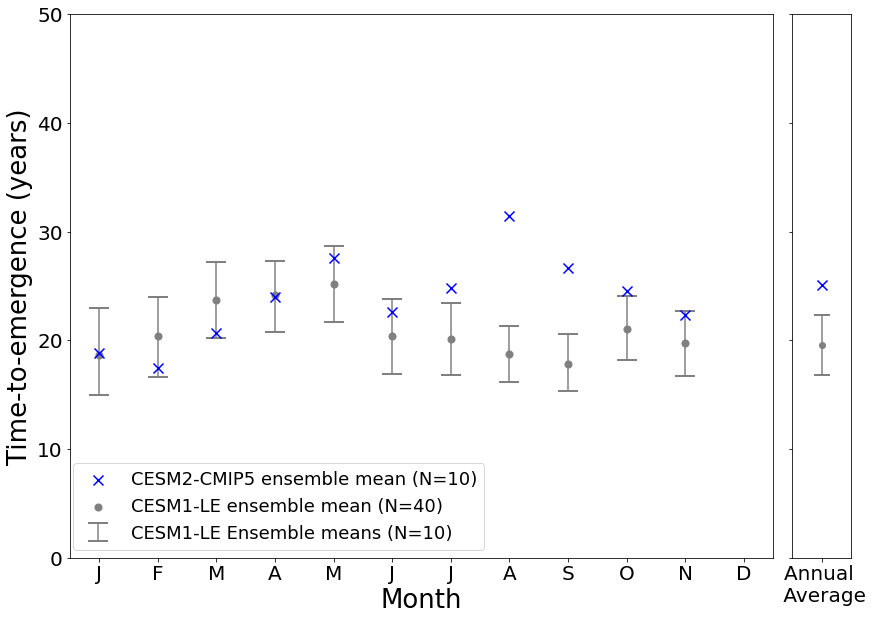

In [55]:
# CESM1-LE emergence bootstrapped to 10 ensemble members.
cesm1le_asr_emergence_bstraps = cesm1le_emergence_LP_bstrap10_ds['FSNTOA']
cesm1le_asr_emergence_mean = cesm1le_emergence_LP_bstrap_ds['FSNTOA'].sel(bound=50.0)

# Mean CESM2-CMIP5 emergence
cesm2cmip5_asr_emergence_mean = cesm2cmip5_emergence_LP['FSNTOA'].mean(dim='ens')

low_err  = cesm1le_asr_emergence_bstraps.sel(bound=50,method='nearest') - cesm1le_asr_emergence_bstraps.sel(bound=2.5,method='nearest')
high_err = cesm1le_asr_emergence_bstraps.sel(bound=97.5,method='nearest') - cesm1le_asr_emergence_bstraps.sel(bound=50,method='nearest')

fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(1, 2,width_ratios=[12,1],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.scatter(cesm2cmip5_asr_emergence_mean.sel(month=slice(1,12)).month, 
            cesm2cmip5_asr_emergence_mean.sel(month=slice(1,12)),
            label='CESM2-CMIP5 ensemble mean (N=10)',
            color='blue',
            marker='x',
            s=100,
            zorder=10,
           )

ax1.errorbar(cesm1le_asr_emergence_bstraps.sel(month=slice(1,12)).month, 
             cesm1le_asr_emergence_bstraps.sel(bound=50,month=slice(1,12)), 
             yerr=[low_err.sel(month=slice(1,12)),high_err.sel(month=slice(1,12))],
             fmt='none',
             # fmt="o",
             label='CESM1-LE Ensemble means (N=10)',
             dash_capstyle='butt',
             # color='black',
             color='grey',
             capsize=10,
             capthick=2,
             alpha=1,
             zorder=1
            )

ax1.scatter(cesm1le_asr_emergence_mean.sel(month=slice(1,12)).month,
            cesm1le_asr_emergence_mean.sel(month=slice(1,12)),
            label='CESM1-LE ensemble mean (N=40)',
            color='grey',
            marker='o',
            s=50,
            alpha=1,
            zorder=9,
           )

ax2.errorbar(1, 
             cesm1le_asr_emergence_bstraps.sel(bound=50,month=13), 
             yerr=[[low_err.sel(month=13)],[high_err.sel(month=13)]], # needs to have shape (2,1)
             fmt="o",
             dash_capstyle='butt',
             # color='black',
             color='grey',
             capsize=8,
             capthick=2,
             zorder=0
            )

ax2.scatter(1,
            cesm2cmip5_asr_emergence_mean.sel(month=13),
            color='blue',
            marker='x',
            s=100,
            zorder=10
           )
            

ax1.set_ylim(0,50)
ax1.set_xlim(0.5,12.5)
ax1.set_ylabel('Time-to-emergence (years)',fontsize=26)
ax1.set_xlabel('Month',fontsize=26)

ax1.set_xticks(np.arange(1,13,1))
ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
# exp_det_ax.yticks(fontsize=15)

# ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)')

ax2.set_xlim(0.5,1.5)
ax2.set_ylim(0,50)

ax2.set_xticks([1])
ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelsize=20)
# ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9)

ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# ax1.set_title('95% confidence intervals on ASR emergence',fontsize=28)


__Weatherhead__

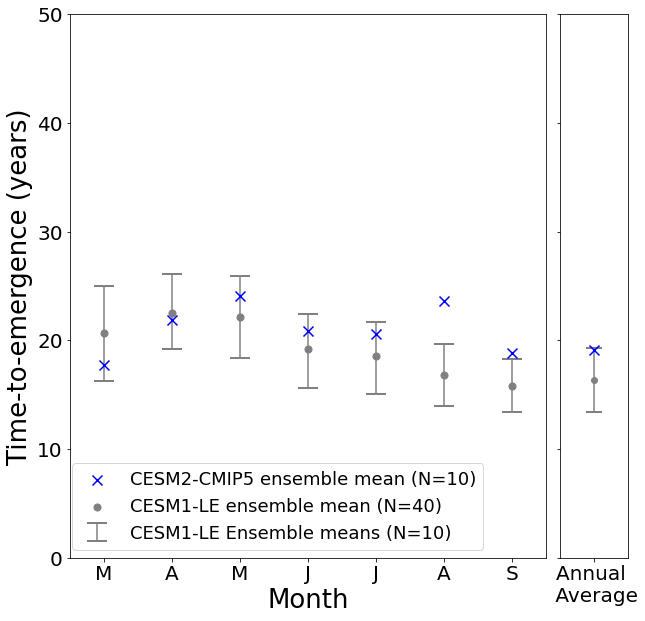

In [59]:
# CESM1-LE emergence bootstrapped to 10 ensemble members.
# asr_emergence_test = emergence_W_allvars['FSNTOA'].sel(month=[3,4,5,6,7,8,9,13])


cesm1le_asr_emergence_bstraps = cesm1le_emergence_W_bstrap10_ds['FSNTOA'].sel(month=[3,4,5,6,7,8,9,13])
cesm1le_asr_emergence_mean = cesm1le_emergence_W_bstrap_ds['FSNTOA'].sel(month=[3,4,5,6,7,8,9,13]).sel(bound=50.0)

# Mean CESM2-CMIP5 emergence
cesm2cmip5_asr_emergence_mean = cesm2cmip5_emergence_W['FSNTOA'].sel(month=[3,4,5,6,7,8,9,13]).mean(dim='ens')

low_err  = cesm1le_asr_emergence_bstraps.sel(bound=50,method='nearest') - cesm1le_asr_emergence_bstraps.sel(bound=2.5,method='nearest')
high_err = cesm1le_asr_emergence_bstraps.sel(bound=97.5,method='nearest') - cesm1le_asr_emergence_bstraps.sel(bound=50,method='nearest')

fig = plt.figure(figsize=(10,10))

gs = gridspec.GridSpec(1, 2,width_ratios=[7,1],figure=fig,wspace=0.05)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


ax1.scatter(cesm2cmip5_asr_emergence_mean.sel(month=slice(3,9)).month, 
            cesm2cmip5_asr_emergence_mean.sel(month=slice(3,9)),
            label='CESM2-CMIP5 ensemble mean (N=10)',
            color='blue',
            marker='x',
            s=100,
            zorder=10,
           )

ax1.errorbar(cesm1le_asr_emergence_bstraps.sel(month=slice(3,9)).month, 
             cesm1le_asr_emergence_bstraps.sel(bound=50,month=slice(3,9)), 
             yerr=[low_err.sel(month=slice(3,9)),high_err.sel(month=slice(3,9))],
             fmt='none',
             # fmt="o",
             label='CESM1-LE Ensemble means (N=10)',
             dash_capstyle='butt',
             # color='black',
             color='grey',
             capsize=10,
             capthick=2,
             alpha=1,
             zorder=1
            )

ax1.scatter(cesm1le_asr_emergence_mean.sel(month=slice(3,9)).month,
            cesm1le_asr_emergence_mean.sel(month=slice(3,9)),
            label='CESM1-LE ensemble mean (N=40)',
            color='grey',
            marker='o',
            s=50,
            alpha=1,
            zorder=9,
           )

ax2.errorbar(1, 
             cesm1le_asr_emergence_bstraps.sel(bound=50,month=13), 
             yerr=[[low_err.sel(month=13)],[high_err.sel(month=13)]], # needs to have shape (2,1)
             fmt="o",
             dash_capstyle='butt',
             # color='black',
             color='grey',
             capsize=8,
             capthick=2,
             zorder=0
            )

ax2.scatter(1,
            cesm2cmip5_asr_emergence_mean.sel(month=13),
            color='blue',
            marker='x',
            s=100,
            zorder=10
           )
            

ax1.set_ylim(0,50)
ax1.set_xlim(2.5,9.5)
ax1.set_ylabel('Time-to-emergence (years)',fontsize=26)
ax1.set_xlabel('Month',fontsize=26)

# ax1.set_xticks(np.arange(1,13,1))
# ax1.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D',],fontsize=20)

ax1.set_xticks(np.arange(3,10,1))
ax1.set_xticklabels(['M','A','M','J','J','A','S',],fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
# exp_det_ax.yticks(fontsize=15)

# ax1.hlines(21,xmin=0.5,xmax=12.5,color='grey',linestyle='dashed',alpha=0.9,label='CERES Record Length (21 years)')

ax2.set_xlim(0.5,1.5)
ax2.set_ylim(0,50)

ax2.set_xticks([1])
ax2.set_xticklabels(['Annual \n Average'],fontsize=20)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', labelsize=20)
# ax2.hlines(21,xmin=0.5,xmax=1.5,color='grey',linestyle='dashed',alpha=0.9)

ax1.legend(facecolor='white',fontsize=18,loc=(0.005,0.015))
# ax1.set_title('95% confidence intervals on ASR emergence',fontsize=28)


The late fall and early winter emerge earlier in CESM1 than CESM2, other months are not statistically different.

In [60]:
to_png(file=fig,filename='fig_ASRemergence_CESM2comparison_Wea',dpi=300,ext='pdf',bbox_inches='tight')

### Combined forced trends and variability plot

Trends 2001-2050  
Variability PIC

__Leroy__

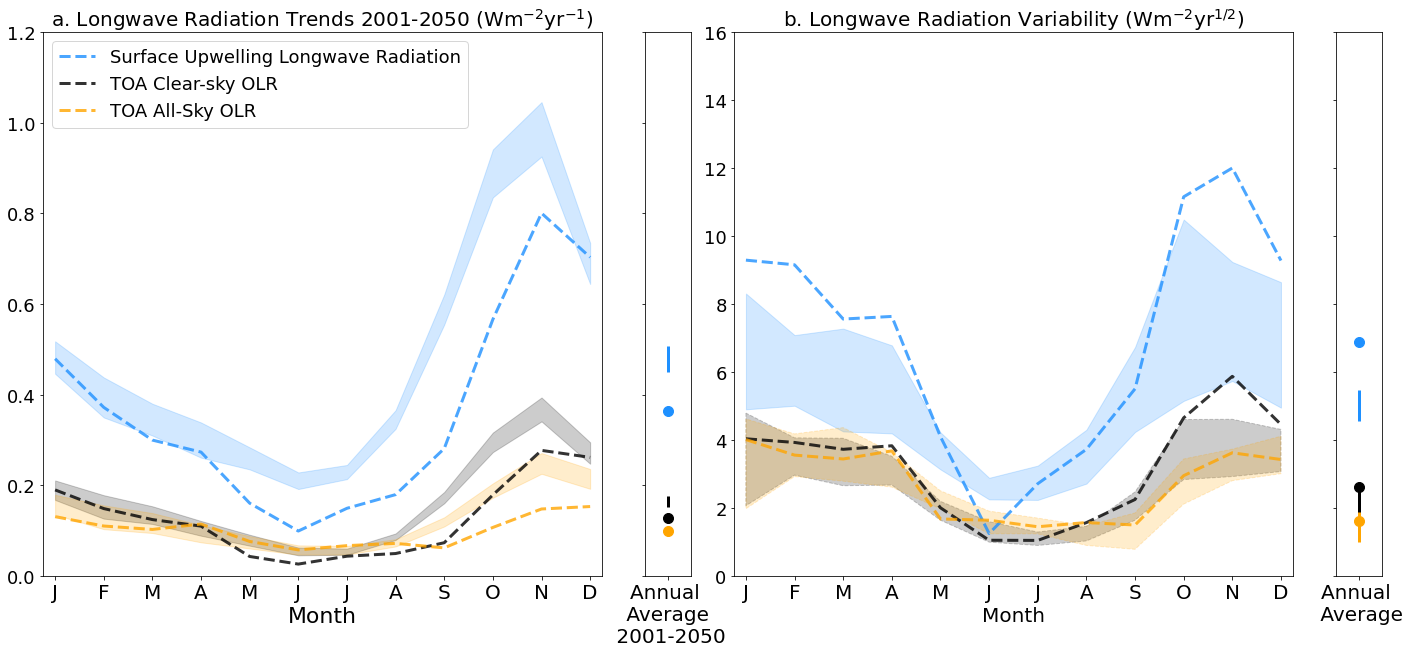

In [61]:
colors = ['dodgerblue','black','orange']

fig = plt.figure(figsize=(24,10))

gs = gridspec.GridSpec(1,4,width_ratios=[12,1,12,1],figure=fig,wspace=0.14)

ceres_ax = plt.subplot(gs[0]) # months
ceres_ax_annual = plt.subplot(gs[1]) # annual

var_ax = plt.subplot(gs[2]) # months
var_ax_annual = plt.subplot(gs[3]) # annual

slopes_2001_2050 = cesm2_cmip5_slopes_all_ds.sel(duration=50).mean(dim='ens')

#### 2001-2050
ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUS'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='Surface Upwelling Longwave Radiation',color=colors[0],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUTC'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='TOA Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUT'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='TOA All-Sky OLR',color=colors[2],linewidth=3,alpha=0.8)


ceres_ax.fill_between(x=np.arange(1,13),
                      y1=cesm1le_slopes_all_bstrap10_ds['FLUS'].sel(month=slice(1,12)).sel(bound=2.5,duration=50,method='nearest'),
                      y2=cesm1le_slopes_all_bstrap10_ds['FLUS'].sel(month=slice(1,12)).sel(bound=97.5,duration=50,method='nearest'),
                      color=colors[0],
                      alpha=0.2,
                     )

ceres_ax.fill_between(x=np.arange(1,13),
                      y1=cesm1le_slopes_all_bstrap10_ds['FLUTC'].sel(month=slice(1,12)).sel(bound=2.5,duration=50,method='nearest'),
                      y2=cesm1le_slopes_all_bstrap10_ds['FLUTC'].sel(month=slice(1,12)).sel(bound=97.5,duration=50,method='nearest'),
                      color=colors[1],
                      alpha=0.2,
                     )

ceres_ax.fill_between(x=np.arange(1,13),
                      y1=cesm1le_slopes_all_bstrap10_ds['FLUT'].sel(month=slice(1,12)).sel(bound=2.5,duration=50,method='nearest'),
                      y2=cesm1le_slopes_all_bstrap10_ds['FLUT'].sel(month=slice(1,12)).sel(bound=97.5,duration=50,method='nearest'),
                      color=colors[2],
                      alpha=0.2,
                     )

ceres_ax.set_ylim(0,1.2)
ceres_ax.tick_params(axis='y', labelsize=18)
# ceres_ax.set_ylabel('OLR Trend 2001-2050 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)
ceres_ax.set_title('a. Longwave Radiation Trends 2001-2050 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

ceres_ax.set_xticks(np.arange(1,13))
ceres_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
ceres_ax.set_xlabel('Month',fontsize=22)
ceres_ax.set_xlim(0.75,12.25)

ceres_ax.legend(fontsize=18,loc='upper left')

ceres_ax_annual.scatter(1,slopes_2001_2050['FLUS'].sel(month=13),
                        color=colors[0],s=100,
                       )

ceres_ax_annual.scatter(1,slopes_2001_2050['FLUTC'].sel(month=13),
                        color=colors[1],s=100,
                       )

ceres_ax_annual.scatter(1,slopes_2001_2050['FLUT'].sel(month=13),
                        color=colors[2],s=100,
                       )

# bstrap error
cesm1le_slopes_all_bstrap10_upper = cesm1le_slopes_all_bstrap10_ds.sel(bound=97.5,duration=50,method='nearest') - cesm1le_slopes_all_bstrap10_ds.sel(bound=50,duration=50,method='nearest')
cesm1le_slopes_all_bstrap10_lower = cesm1le_slopes_all_bstrap10_ds.sel(bound=50,duration=50,method='nearest') - cesm1le_slopes_all_bstrap10_ds.sel(bound=2.5,duration=50,method='nearest')

ceres_ax_annual.errorbar(1, 
                         cesm1le_slopes_all_bstrap10_ds['FLUS'].sel(bound=50,duration=50,month=13), 
                         yerr=[[cesm1le_slopes_all_bstrap10_upper['FLUS'].sel(month=13)],[cesm1le_slopes_all_bstrap10_lower['FLUS'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[0],linewidth=3,
                         zorder=0
                        )

ceres_ax_annual.errorbar(1, 
                         cesm1le_slopes_all_bstrap10_ds['FLUTC'].sel(bound=50,duration=50,month=13), 
                         yerr=[[cesm1le_slopes_all_bstrap10_upper['FLUTC'].sel(month=13)],[cesm1le_slopes_all_bstrap10_lower['FLUTC'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[1],linewidth=3,
                         zorder=0
                        )

ceres_ax_annual.errorbar(1, 
                         cesm1le_slopes_all_bstrap10_ds['FLUT'].sel(bound=50,duration=50,month=13), 
                         yerr=[[cesm1le_slopes_all_bstrap10_upper['FLUT'].sel(month=13)],[cesm1le_slopes_all_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[2],linewidth=3,
                         zorder=0
                        )


ceres_ax_annual.set_xticks([1])
ceres_ax_annual.set_xticklabels(['Annual \n Average \n 2001-2050'],fontsize=20)
ceres_ax_annual.set_yticklabels([])
ceres_ax_annual.tick_params(axis='y', labelsize=20)

ceres_ax_annual.set_xlim(0.5,1.5)
ceres_ax_annual.set_ylim(0,1.2)

# Net variability in the right panel
netvar_all_cesm2cmip5     = cesm2_cmip5_stddevs_all_ds * cesm2_cmip5_tauvars_LP_all_ds.map(np.sqrt)
netvar_annual_cesm2cmip5  = netvar_all_cesm2cmip5.sel(month=13)
netvar_monthly_cesm2cmip5 = netvar_all_cesm2cmip5.sel(month=slice(1,12))

netvar_all_cesm1le     = cesm1le_stddevs_all_ds * cesm1le_tauvars_LP_all_ds.map(np.sqrt)
netvar_annual_cesm1le  = netvar_all_cesm1le.sel(month=13)
netvar_monthly_cesm1le = netvar_all_cesm1le.sel(month=slice(1,12))

var_ax.plot(np.arange(1,13),netvar_monthly_cesm2cmip5['FLUS'],
            linestyle='dashed',label='Surface OLR',color=colors[0],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly_cesm2cmip5['FLUTC'],
            linestyle='dashed',label='Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly_cesm2cmip5['FLUT'],
            linestyle='dashed',label='OLR',color=colors[2],linewidth=3,alpha=0.8)

# Plot confidence interval
var_ax.fill_between(np.arange(1,13),
                    y1=startyear_netvar_cesm1le_LP_low['FLUS'].sel(month=slice(1,12)),
                    y2=startyear_netvar_cesm1le_LP_high['FLUS'].sel(month=slice(1,12)),
                    label='Surface OLR',color=colors[0],alpha=0.2)

var_ax.fill_between(np.arange(1,13),
                    y1=startyear_netvar_cesm1le_LP_low['FLUTC'].sel(month=slice(1,12)),
                    y2=startyear_netvar_cesm1le_LP_high['FLUTC'].sel(month=slice(1,12)),
                    linestyle='dashed',label='Clear-sky OLR',color=colors[1],alpha=0.2)

var_ax.fill_between(np.arange(1,13),
                    y1=startyear_netvar_cesm1le_LP_low['FLUT'].sel(month=slice(1,12)),
                    y2=startyear_netvar_cesm1le_LP_high['FLUT'].sel(month=slice(1,12)),
                    linestyle='dashed',label='OLR',color=colors[2],alpha=0.2)


var_ax.tick_params(axis='y', labelsize=18)
# var_ax.set_ylabel('Longwave Radiation Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
var_ax.set_title('b. Longwave Radiation Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
# var_ax.set_ylabel('Longwave Radiation Standard Deviation (Wm$^{-2}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

var_ax.set_xticks(np.arange(1,13))
var_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
var_ax.set_xlabel('Month',fontsize=20)
var_ax.set_xlim(0.75,12.25)
var_ax.set_ylim(0,16)

var_ax_annual.scatter(1,netvar_annual_cesm2cmip5['FLUS'],
                    color=colors[0],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )

var_ax_annual.scatter(1,netvar_annual_cesm2cmip5['FLUTC'],
                    color=colors[1],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )

var_ax_annual.scatter(1,netvar_annual_cesm2cmip5['FLUT'],
                    color=colors[2],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )
                
# Plot confidence intervals
cesm1le_netvar_bstrap10_upper = startyear_netvar_cesm1le_LP_high - startyear_netvar_cesm1le_LP_mid
cesm1le_netvar_bstrap10_lower = startyear_netvar_cesm1le_LP_mid - startyear_netvar_cesm1le_LP_low

var_ax_annual.errorbar(1, 
                         startyear_netvar_cesm1le_LP_mid['FLUS'].sel(month=13), 
                         yerr=[[cesm1le_netvar_bstrap10_upper['FLUS'].sel(month=13)],[cesm1le_netvar_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[0],linewidth=3,
                         zorder=0
                        )

var_ax_annual.errorbar(1, 
                         startyear_netvar_cesm1le_LP_mid['FLUTC'].sel(month=13), 
                         yerr=[[cesm1le_netvar_bstrap10_upper['FLUTC'].sel(month=13)],[cesm1le_netvar_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[1],linewidth=3,
                         zorder=0
                        )

var_ax_annual.errorbar(1, 
                         startyear_netvar_cesm1le_LP_mid['FLUT'].sel(month=13), 
                         yerr=[[cesm1le_netvar_bstrap10_upper['FLUT'].sel(month=13)],[cesm1le_netvar_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[2],linewidth=3,
                         zorder=0
                        )
    
var_ax_annual.set_xlim(0.5,1.5)
var_ax_annual.set_ylim(0,16)

var_ax_annual.set_xticks([1])
var_ax_annual.set_xticklabels(['Annual \n Average'],fontsize=20)
var_ax_annual.set_yticklabels([])
var_ax_annual.tick_params(axis='y', labelsize=20)

In [142]:
# to_png(file=fig,filename='fig_CESM2_trendsandvariability',dpi=300,ext='pdf',bbox_inches='tight')

__Weatherhead__

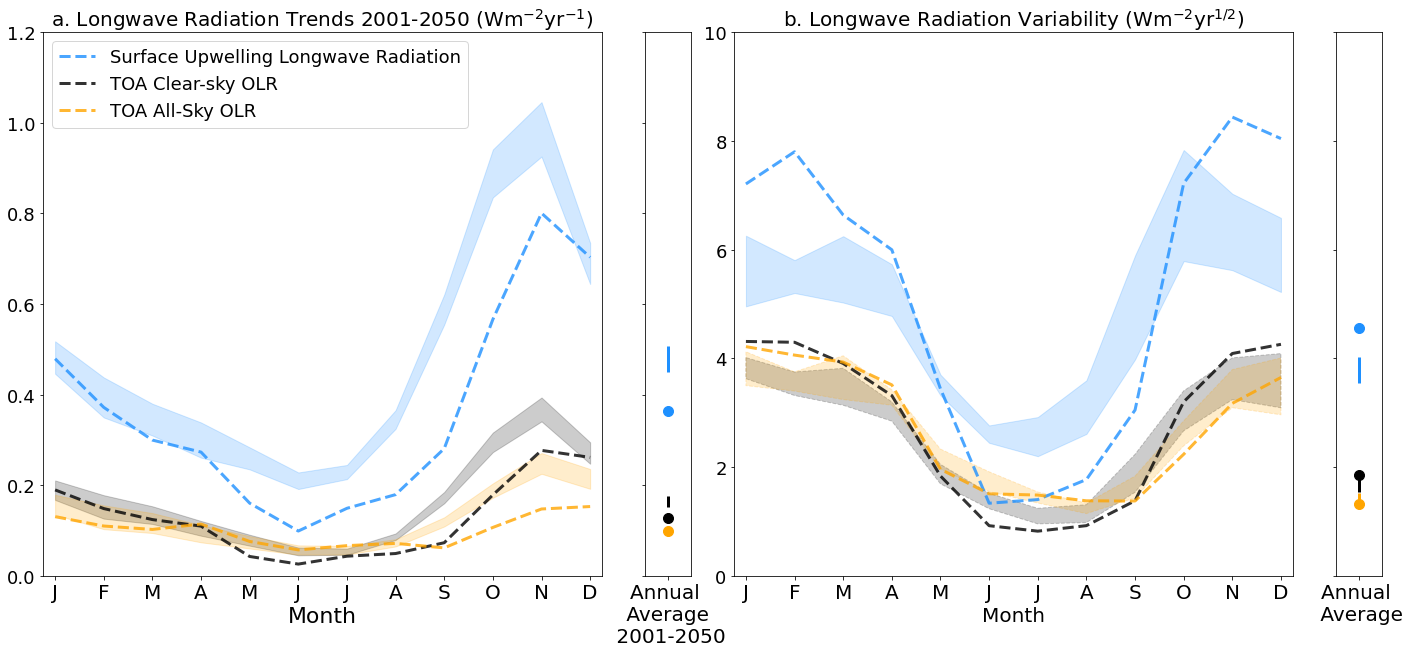

In [65]:
colors = ['dodgerblue','black','orange']

fig = plt.figure(figsize=(24,10))

gs = gridspec.GridSpec(1,4,width_ratios=[12,1,12,1],figure=fig,wspace=0.14)

ceres_ax = plt.subplot(gs[0]) # months
ceres_ax_annual = plt.subplot(gs[1]) # annual

var_ax = plt.subplot(gs[2]) # months
var_ax_annual = plt.subplot(gs[3]) # annual

slopes_2001_2050 = cesm2_cmip5_slopes_all_ds.sel(duration=50).mean(dim='ens')

#### 2001-2050
ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUS'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='Surface Upwelling Longwave Radiation',color=colors[0],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUTC'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='TOA Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050['FLUT'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='TOA All-Sky OLR',color=colors[2],linewidth=3,alpha=0.8)


ceres_ax.fill_between(x=np.arange(1,13),
                      y1=cesm1le_slopes_all_bstrap10_ds['FLUS'].sel(month=slice(1,12)).sel(bound=2.5,duration=50,method='nearest'),
                      y2=cesm1le_slopes_all_bstrap10_ds['FLUS'].sel(month=slice(1,12)).sel(bound=97.5,duration=50,method='nearest'),
                      color=colors[0],
                      alpha=0.2,
                     )

ceres_ax.fill_between(x=np.arange(1,13),
                      y1=cesm1le_slopes_all_bstrap10_ds['FLUTC'].sel(month=slice(1,12)).sel(bound=2.5,duration=50,method='nearest'),
                      y2=cesm1le_slopes_all_bstrap10_ds['FLUTC'].sel(month=slice(1,12)).sel(bound=97.5,duration=50,method='nearest'),
                      color=colors[1],
                      alpha=0.2,
                     )

ceres_ax.fill_between(x=np.arange(1,13),
                      y1=cesm1le_slopes_all_bstrap10_ds['FLUT'].sel(month=slice(1,12)).sel(bound=2.5,duration=50,method='nearest'),
                      y2=cesm1le_slopes_all_bstrap10_ds['FLUT'].sel(month=slice(1,12)).sel(bound=97.5,duration=50,method='nearest'),
                      color=colors[2],
                      alpha=0.2,
                     )

ceres_ax.set_ylim(0,1.2)
ceres_ax.tick_params(axis='y', labelsize=18)
# ceres_ax.set_ylabel('OLR Trend 2001-2050 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)
ceres_ax.set_title('a. Longwave Radiation Trends 2001-2050 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

ceres_ax.set_xticks(np.arange(1,13))
ceres_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
ceres_ax.set_xlabel('Month',fontsize=22)
ceres_ax.set_xlim(0.75,12.25)

ceres_ax.legend(fontsize=18,loc='upper left')

ceres_ax_annual.scatter(1,slopes_2001_2050['FLUS'].sel(month=13),
                        color=colors[0],s=100,
                       )

ceres_ax_annual.scatter(1,slopes_2001_2050['FLUTC'].sel(month=13),
                        color=colors[1],s=100,
                       )

ceres_ax_annual.scatter(1,slopes_2001_2050['FLUT'].sel(month=13),
                        color=colors[2],s=100,
                       )

# bstrap error
cesm1le_slopes_all_bstrap10_upper = cesm1le_slopes_all_bstrap10_ds.sel(bound=97.5,duration=50,method='nearest') - cesm1le_slopes_all_bstrap10_ds.sel(bound=50,duration=50,method='nearest')
cesm1le_slopes_all_bstrap10_lower = cesm1le_slopes_all_bstrap10_ds.sel(bound=50,duration=50,method='nearest') - cesm1le_slopes_all_bstrap10_ds.sel(bound=2.5,duration=50,method='nearest')

ceres_ax_annual.errorbar(1, 
                         cesm1le_slopes_all_bstrap10_ds['FLUS'].sel(bound=50,duration=50,month=13), 
                         yerr=[[cesm1le_slopes_all_bstrap10_upper['FLUS'].sel(month=13)],[cesm1le_slopes_all_bstrap10_lower['FLUS'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[0],linewidth=3,
                         zorder=0
                        )

ceres_ax_annual.errorbar(1, 
                         cesm1le_slopes_all_bstrap10_ds['FLUTC'].sel(bound=50,duration=50,month=13), 
                         yerr=[[cesm1le_slopes_all_bstrap10_upper['FLUTC'].sel(month=13)],[cesm1le_slopes_all_bstrap10_lower['FLUTC'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[1],linewidth=3,
                         zorder=0
                        )

ceres_ax_annual.errorbar(1, 
                         cesm1le_slopes_all_bstrap10_ds['FLUT'].sel(bound=50,duration=50,month=13), 
                         yerr=[[cesm1le_slopes_all_bstrap10_upper['FLUT'].sel(month=13)],[cesm1le_slopes_all_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[2],linewidth=3,
                         zorder=0
                        )


ceres_ax_annual.set_xticks([1])
ceres_ax_annual.set_xticklabels(['Annual \n Average \n 2001-2050'],fontsize=20)
ceres_ax_annual.set_yticklabels([])
ceres_ax_annual.tick_params(axis='y', labelsize=20)

ceres_ax_annual.set_xlim(0.5,1.5)
ceres_ax_annual.set_ylim(0,1.2)

# Net variability in the right panel
netvar_all_cesm2cmip5     = cesm2_cmip5_stddevs_all_ds * cesm2_cmip5_tauvars_W_all_ds.map(np.sqrt)
netvar_annual_cesm2cmip5  = netvar_all_cesm2cmip5.sel(month=13)
netvar_monthly_cesm2cmip5 = netvar_all_cesm2cmip5.sel(month=slice(1,12))

netvar_all_cesm1le     = cesm1le_stddevs_all_ds * cesm1le_tauvars_W_all_ds.map(np.sqrt)
netvar_annual_cesm1le  = netvar_all_cesm1le.sel(month=13)
netvar_monthly_cesm1le = netvar_all_cesm1le.sel(month=slice(1,12))

var_ax.plot(np.arange(1,13),netvar_monthly_cesm2cmip5['FLUS'],
            linestyle='dashed',label='Surface OLR',color=colors[0],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly_cesm2cmip5['FLUTC'],
            linestyle='dashed',label='Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly_cesm2cmip5['FLUT'],
            linestyle='dashed',label='OLR',color=colors[2],linewidth=3,alpha=0.8)

# Plot confidence interval
var_ax.fill_between(np.arange(1,13),
                    y1=startyear_netvar_cesm1le_W_low['FLUS'].sel(month=slice(1,12)),
                    y2=startyear_netvar_cesm1le_W_high['FLUS'].sel(month=slice(1,12)),
                    label='Surface OLR',color=colors[0],alpha=0.2)

var_ax.fill_between(np.arange(1,13),
                    y1=startyear_netvar_cesm1le_W_low['FLUTC'].sel(month=slice(1,12)),
                    y2=startyear_netvar_cesm1le_W_high['FLUTC'].sel(month=slice(1,12)),
                    linestyle='dashed',label='Clear-sky OLR',color=colors[1],alpha=0.2)

var_ax.fill_between(np.arange(1,13),
                    y1=startyear_netvar_cesm1le_W_low['FLUT'].sel(month=slice(1,12)),
                    y2=startyear_netvar_cesm1le_W_high['FLUT'].sel(month=slice(1,12)),
                    linestyle='dashed',label='OLR',color=colors[2],alpha=0.2)


var_ax.tick_params(axis='y', labelsize=18)
# var_ax.set_ylabel('Longwave Radiation Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
var_ax.set_title('b. Longwave Radiation Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
# var_ax.set_ylabel('Longwave Radiation Standard Deviation (Wm$^{-2}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

var_ax.set_xticks(np.arange(1,13))
var_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
var_ax.set_xlabel('Month',fontsize=20)
var_ax.set_xlim(0.75,12.25)
var_ax.set_ylim(0,10)

var_ax_annual.scatter(1,netvar_annual_cesm2cmip5['FLUS'],
                    color=colors[0],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )

var_ax_annual.scatter(1,netvar_annual_cesm2cmip5['FLUTC'],
                    color=colors[1],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )

var_ax_annual.scatter(1,netvar_annual_cesm2cmip5['FLUT'],
                    color=colors[2],s=100,
                    # linestyle='dashed',label='Surface OLR',color='purple',linewidth=3,alpha=0.8,
                   )
                
# Plot confidence intervals
cesm1le_netvar_bstrap10_upper = startyear_netvar_cesm1le_W_high - startyear_netvar_cesm1le_W_mid
cesm1le_netvar_bstrap10_lower = startyear_netvar_cesm1le_W_mid - startyear_netvar_cesm1le_W_low

var_ax_annual.errorbar(1, 
                         startyear_netvar_cesm1le_W_mid['FLUS'].sel(month=13), 
                         yerr=[[cesm1le_netvar_bstrap10_upper['FLUS'].sel(month=13)],[cesm1le_netvar_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[0],linewidth=3,
                         zorder=0
                        )

var_ax_annual.errorbar(1, 
                         startyear_netvar_cesm1le_W_mid['FLUTC'].sel(month=13), 
                         yerr=[[cesm1le_netvar_bstrap10_upper['FLUTC'].sel(month=13)],[cesm1le_netvar_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[1],linewidth=3,
                         zorder=0
                        )

var_ax_annual.errorbar(1, 
                         startyear_netvar_cesm1le_W_mid['FLUT'].sel(month=13), 
                         yerr=[[cesm1le_netvar_bstrap10_upper['FLUT'].sel(month=13)],[cesm1le_netvar_bstrap10_lower['FLUT'].sel(month=13)]], # needs to have shape (2,1)
                         fmt="none",
                         color=colors[2],linewidth=3,
                         zorder=0
                        )
    
var_ax_annual.set_xlim(0.5,1.5)
var_ax_annual.set_ylim(0,10)

var_ax_annual.set_xticks([1])
var_ax_annual.set_xticklabels(['Annual \n Average'],fontsize=20)
var_ax_annual.set_yticklabels([])
var_ax_annual.tick_params(axis='y', labelsize=20)

In [66]:
to_png(file=fig,filename='fig_CESM2_trendsandvariability_Wea',dpi=300,ext='pdf',bbox_inches='tight')

### Combined forced trends and variability plot (differences with CESM1)

Trends 2001-2050  
Variability PIC

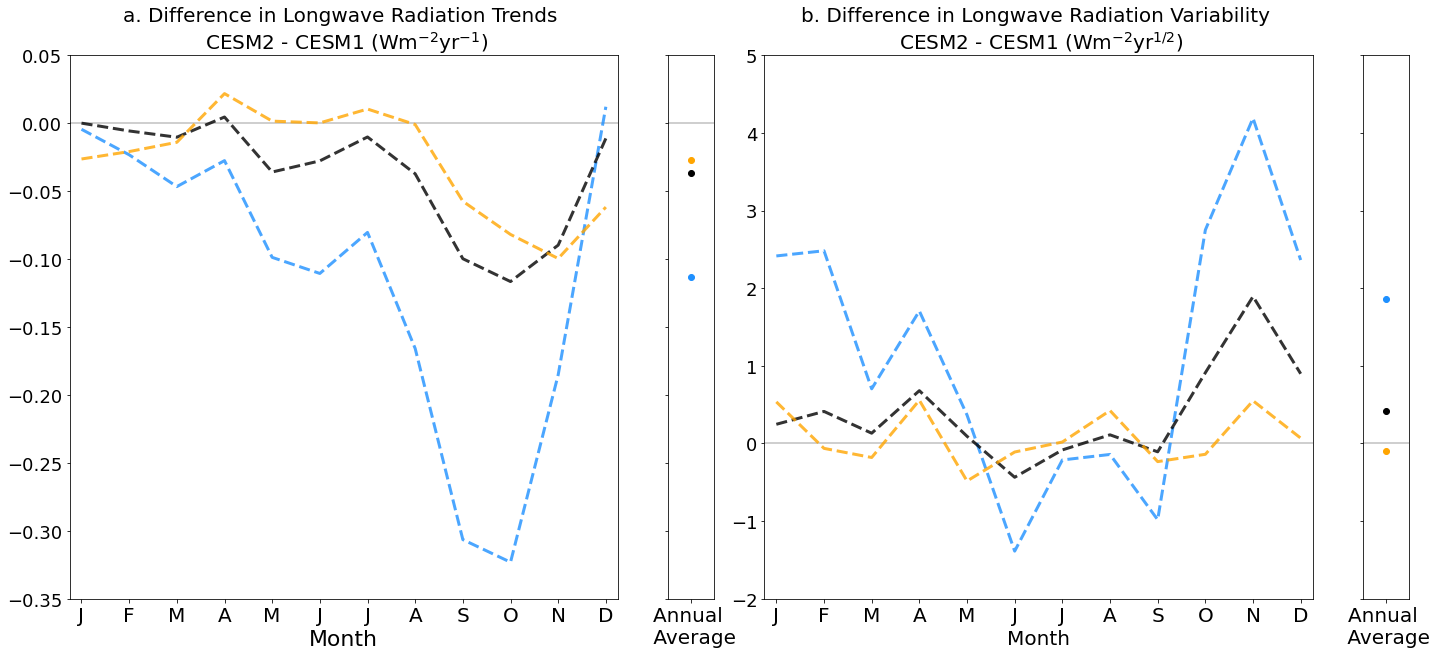

In [80]:
colors = ['dodgerblue','black','orange']

fig = plt.figure(figsize=(24,10))

gs = gridspec.GridSpec(1,4,width_ratios=[12,1,12,1],figure=fig,wspace=0.17)

ceres_ax = plt.subplot(gs[0]) # months
ceres_ax_annual = plt.subplot(gs[1]) # annual

var_ax = plt.subplot(gs[2]) # months
var_ax_annual = plt.subplot(gs[3]) # annual

slopes_2001_2050_cesm2cmip5 = cesm2_cmip5_slopes_all_ds.sel(duration=50).mean(dim='ens')
slopes_2001_2050_cesm1le    = cesm1le_slopes_all_ds.sel(duration=50).mean(dim='ens')
slopes_2001_2050_diff       = slopes_2001_2050_cesm2cmip5 - slopes_2001_2050_cesm1le

#### 2001-20250
ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050_diff['FLUS'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='Surface OLR',color=colors[0],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050_diff['FLUTC'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

ceres_ax.errorbar(x=np.arange(1,13),y=slopes_2001_2050_diff['FLUT'].sel(month=slice(1,12)),yerr=None,
                linestyle='dashed',label='OLR',color=colors[2],linewidth=3,alpha=0.8)

ceres_ax.tick_params(axis='y', labelsize=18)
# ceres_ax.set_ylabel('OLR Trend 2001-2050 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)
# ceres_ax.set_title('a. Longwave Radiation Trends \n CESM2 minus CESM1 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)
ceres_ax.set_title('a. Difference in Longwave Radiation Trends \n CESM2 - CESM1 (Wm$^{-2}$yr$^{-1}$)',fontsize=20)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

ceres_ax.set_xticks(np.arange(1,13))
ceres_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
ceres_ax.set_xlabel('Month',fontsize=22)

ceres_ax.hlines(0,0.75,12.25,color='gray',alpha=0.5,zorder=0)

ceres_ax.set_xlim(0.75,12.25)
ceres_ax.set_ylim(-0.35,0.05)


ceres_ax_annual.scatter(1,slopes_2001_2050_diff['FLUS'].sel(month=13),
                        color=colors[0],
                       )

ceres_ax_annual.scatter(1,slopes_2001_2050_diff['FLUTC'].sel(month=13),
                        color=colors[1],
                       )

ceres_ax_annual.scatter(1,slopes_2001_2050_diff['FLUT'].sel(month=13),
                        color=colors[2],
                       )

ceres_ax_annual.set_xticks([1])
ceres_ax_annual.set_xticklabels(['Annual \n Average'],fontsize=20)
# ceres_ax_annual.set_xticklabels(['Annual \n Average \n 2001-2050'],fontsize=20)
ceres_ax_annual.set_yticklabels([])
ceres_ax_annual.tick_params(axis='y', labelsize=20)

ceres_ax_annual.hlines(0,0.5,1.5,color='gray',alpha=0.5,zorder=0)

ceres_ax_annual.set_xlim(0.5,1.5)
ceres_ax_annual.set_ylim(-0.35,0.05)
# ceres_ax_annual.set_ylim(0,1)

# Net variability in the right panel
netvar_all_cesm2cmip5  = cesm2_cmip5_stddevs_all_ds * cesm2_cmip5_tauvars_LP_all_ds.map(np.sqrt)
netvar_all_cesm1le     = cesm1le_stddevs_all_ds * cesm1le_tauvars_LP_all_ds.map(np.sqrt)
netvar_all_diff = netvar_all_cesm2cmip5 - netvar_all_cesm1le

netvar_annual  = netvar_all_diff.sel(month=13)
netvar_monthly = netvar_all_diff.sel(month=slice(1,12))

var_ax.plot(np.arange(1,13),netvar_monthly['FLUS'],
            linestyle='dashed',label='Surface OLR',color=colors[0],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly['FLUTC'],
            linestyle='dashed',label='Clear-sky OLR',color=colors[1],linewidth=3,alpha=0.8)

var_ax.plot(np.arange(1,13),netvar_monthly['FLUT'],
            linestyle='dashed',label='OLR',color=colors[2],linewidth=3,alpha=0.8)

var_ax.hlines(0,0.75,12.25,color='gray',alpha=0.5,zorder=0)

var_ax.tick_params(axis='y', labelsize=18)
# var_ax.set_ylabel('Longwave Radiation Variability (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
var_ax.set_title('b. Difference in Longwave Radiation Variability \n CESM2 - CESM1 (Wm$^{-2}$yr$^{1/2}$)',fontsize=20)
# var_ax.set_ylabel('Longwave Radiation Standard Deviation (Wm$^{-2}$)',fontsize=20)
var_ax.set_xlim(0.75,12.25)
var_ax.set_ylim(-0.35,0.05)

month_abbrevs = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

var_ax.set_xticks(np.arange(1,13))
var_ax.set_xticklabels(month_abbrevs[:-1],fontsize=20)
var_ax.set_xlabel('Month',fontsize=20)
var_ax.set_xlim(0.75,12.25)
var_ax.set_ylim(-2,5)

var_ax_annual.scatter(1,netvar_annual['FLUS'],
                    color=colors[0],
                   )

var_ax_annual.scatter(1,netvar_annual['FLUTC'],
                    color=colors[1],
                   )

var_ax_annual.scatter(1,netvar_annual['FLUT'],
                    color=colors[2],
                   )

var_ax_annual.hlines(0,0.5,1.5,color='gray',alpha=0.5,zorder=0)
                
var_ax_annual.set_xlim(0.5,1.5)
var_ax_annual.set_ylim(-2,5)

var_ax_annual.set_xticks([1])
var_ax_annual.set_xticklabels(['Annual \n Average'],fontsize=20)
var_ax_annual.set_yticklabels([])
var_ax_annual.tick_params(axis='y', labelsize=20)

In [82]:
# to_png(file=fig,filename='fig_CESM2_trendsandvariability_difference',dpi=300,ext='pdf',bbox_inches='tight')

### Plot differences in melt season ASR and fall OLR to explain differences in surface warming.

In [55]:
cesm2cmip5_ensemblemembers_histfile = '%s/%s' % (cesm2cmip5_tseries_savedir,'CESM2_CMIP5_Members_HIST1920_2000_ArcticTimeSeries.nc')
cesm2cmip5_ensemblemembers_rcpfile  = '%s/%s' % (cesm2cmip5_tseries_savedir,'CESM2_CMIP5_RCP8.5Members_ArcticTimeSeries.nc')

cesm1le_ensemblemembers_histfile    = '%s/%s' % (cesm1le_tseries_savedir,'CESM1_Members_HIST1920_2000_ArcticTimeSeries.nc')
cesm1le_ensemblemembers_rcpfile     = '%s/%s' % (cesm1le_tseries_savedir,'CESM1_RCP8.5Members_ArcticTimeSeries.nc')

In [56]:
cesm2cmip5_fulltseries = xr.open_mfdataset([cesm2cmip5_ensemblemembers_histfile,cesm2cmip5_ensemblemembers_rcpfile])
cesm1le_fulltseries    = xr.open_mfdataset([cesm1le_ensemblemembers_histfile,cesm1le_ensemblemembers_rcpfile])

In [57]:
cesm2cmip5_picfile = '%s/%s' % (cesm2cmip5_tseries_savedir,'CESM2_CMIP5_PIControl_ArcticTimeSeries.nc')
cesm1le_picfile    = '%s/%s' % (cesm1le_tseries_savedir,'CESM1_PIControl_ArcticTimeSeries.nc')

In [58]:
cesm2cmip5_pic_ds = xr.open_dataset(cesm2cmip5_picfile)
cesm1le_pic_ds = xr.open_dataset(cesm1le_picfile)

Variable processing for historical + forced timeseries.

In [59]:
# Add surface upwelling radiation variable
cesm2cmip5_fulltseries['FLUS'] = cesm2cmip5_fulltseries['FLNS'] + cesm2cmip5_fulltseries['FLDS']
cesm1le_fulltseries['FLUS']    = cesm1le_fulltseries['FLNS'] + cesm1le_fulltseries['FLDS']

# Sum over the cloud optical depths
cesm2cmip5_fulltseries['CLDTAU'] = cesm2cmip5_fulltseries['TOT_CLD_VISTAU'].sum(dim='lev')
cesm1le_fulltseries['CLDTAU']    = cesm1le_fulltseries['TOT_CLD_VISTAU'].sum(dim='lev')

cesm2cmip5_fulltseries = cesm2cmip5_fulltseries.drop(['TOT_CLD_VISTAU','lev'])
cesm1le_fulltseries    = cesm1le_fulltseries.drop(['TOT_CLD_VISTAU','lev'])

Variable processing for pre-industrial timeseries.

In [60]:
# Add surface upwelling radiation variable
cesm2cmip5_pic_ds['FLUS'] = cesm2cmip5_pic_ds['FLNS'] + cesm2cmip5_pic_ds['FLDS']
cesm1le_pic_ds['FLUS']    = cesm1le_pic_ds['FLNS'] + cesm1le_pic_ds['FLDS']

#### Bootstrap CESM1-LE to 10 members w/ confidence intervals.

I need to re-organize so that it is indexed by year and month instead of time. This will allow me to bootstrap efficiently.

In [61]:
cesm1le_fulltseries    = cesm1le_fulltseries.assign_coords({'year':cesm1le_fulltseries['time.year'],
                                                            'month':cesm1le_fulltseries['time.month'],
                                                           }
                                                          )
cesm2cmip5_fulltseries = cesm2cmip5_fulltseries.assign_coords({'year':cesm2cmip5_fulltseries['time.year'],
                                                               'month':cesm2cmip5_fulltseries['time.month'],
                                                              }
                                                             )


cesm1le_pic_ds    = cesm1le_pic_ds.assign_coords({'year':cesm1le_pic_ds['time.year'],
                                                  'month':cesm1le_pic_ds['time.month'],
                                                 }
                                                )
cesm2cmip5_pic_ds = cesm2cmip5_pic_ds.assign_coords({'year':cesm2cmip5_pic_ds['time.year'],
                                                     'month':cesm2cmip5_pic_ds['time.month'],
                                                    }
                                                   )

In [62]:
cesm1le_tseries_reorg = cesm1le_fulltseries.to_dataframe().reset_index().set_index(['year','month','ens']).to_xarray().drop('time')
cesm2cmip5_tseries_reorg = cesm2cmip5_fulltseries.to_dataframe().reset_index().set_index(['year','month','ens']).to_xarray().drop('time')

cesm1le_pic_reorg = cesm1le_pic_ds.to_dataframe().reset_index().set_index(['year','month']).to_xarray().drop('time')
cesm2cmip5_pic_reorg = cesm2cmip5_pic_ds.to_dataframe().reset_index().set_index(['year','month']).to_xarray().drop('time')

del cesm1le_fulltseries,cesm2cmip5_fulltseries,cesm1le_pic_ds,cesm2cmip5_pic_ds

#### Calculate the total shortwave radiative energy absorbed over the melt season (a la Sledd et als)

We therefore calculate the net SW energy absorbed over the melt season, March through September. These months account for 95% of incoming SW radiation in the Arctic (Cao et al. 2016). The accumulated SW, $SW_{acc}$, is found by calculating the net SW flux absorbed at each grid box multiplied by the area of its grid box, converting it to a measure of power. Further multiplying by the duration (in seconds) of each month yields an accumulated energy. This average net SW energy is then summed over the Arctic, again defined as the area north of the Arctic Circle, and summed over the melt season:

$$ SW_{acc} = \sum_{m=3}^{m=9} \sum_{i,j} (SW^{\downarrow} - SW^{\uparrow})_{i,j} \times A_{i,j} \times t_m $$

My timeseries are already spatially averaged, so I will ignore the area term. I just need to know the number of seconds per month.

In [63]:
days_per_month = [31,28,31,30,31,30,31,31,30,31,30,31]

seconds_per_month = np.array(days_per_month) * 24 * 60 * 60 # day/month * 24hours/day * 60min/hour * 60sec/min

In [64]:
seconds_per_month_da = xr.DataArray(data = seconds_per_month,
                                    dims = ['month'],
                                    coords = {'month':np.arange(1,13)},
                                    name = 'seconds per month'
                                   )


Accumulated shortwave calculation.

Historical and forced.

In [65]:
sw_acc_cesm1         = (cesm1le_tseries_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm1 = (cesm1le_tseries_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

sw_acc_cesm2         = (cesm2cmip5_tseries_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm2 = (cesm2cmip5_tseries_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

In [66]:
sw_acc_cesm1 = sw_acc_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                         })

sw_acc_surface_cesm1 = sw_acc_surface_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                         })

sw_acc_cesm2 = sw_acc_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                         })

sw_acc_surface_cesm2 = sw_acc_surface_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                         })

In [67]:
cesm1le_tseries_reorg['SW_ACC_TOA'] = sw_acc_cesm1
cesm1le_tseries_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm1

cesm2cmip5_tseries_reorg['SW_ACC_TOA'] = sw_acc_cesm2
cesm2cmip5_tseries_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm2

del sw_acc_cesm1,sw_acc_surface_cesm1
del sw_acc_cesm2,sw_acc_surface_cesm2

Pre-Industrial.

In [68]:
sw_acc_cesm1_pic         = (cesm1le_pic_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm1_pic = (cesm1le_pic_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

sw_acc_cesm2_pic         = (cesm2cmip5_pic_reorg['FSNTOA']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')
sw_acc_surface_cesm2_pic = (cesm2cmip5_pic_reorg['FSNS']*seconds_per_month_da).sel(month=slice(3,9)).sum(dim='month')

In [69]:
sw_acc_cesm1_pic = sw_acc_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                 })

sw_acc_surface_cesm1_pic = sw_acc_surface_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                                 })

sw_acc_cesm2_pic = sw_acc_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                 })

sw_acc_surface_cesm2_pic = sw_acc_surface_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface shortwave energy Accumulated over the melt season (March-September) per unit area'
                                                                 })

In [70]:
cesm1le_pic_reorg['SW_ACC_TOA'] = sw_acc_cesm1_pic
cesm1le_pic_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm1_pic

cesm2cmip5_pic_reorg['SW_ACC_TOA'] = sw_acc_cesm2_pic
cesm2cmip5_pic_reorg['SW_ACC_SURFACE'] = sw_acc_surface_cesm2_pic

del sw_acc_cesm1_pic,sw_acc_surface_cesm1_pic
del sw_acc_cesm2_pic,sw_acc_surface_cesm2_pic

Heat season longwave calculation.

Historical and forced.

In [71]:
lw_emm_cesm1         = (cesm1le_tseries_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm1 = (cesm1le_tseries_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

lw_emm_cesm2         = (cesm2cmip5_tseries_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm2 = (cesm2cmip5_tseries_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

In [72]:
lw_emm_cesm1 = lw_emm_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                         })

lw_emm_surface_cesm1 = lw_emm_surface_cesm1.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface longwave energy emitted over October-December per unit area'
                                                         })

lw_emm_cesm2 = lw_emm_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                          'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                         })

lw_emm_surface_cesm2 = lw_emm_surface_cesm2.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                          'description':'Surface longwave energy emitted over October-December per unit area'
                                                         })

In [73]:
cesm1le_tseries_reorg['LW_EMM_TOA'] = lw_emm_cesm1
cesm1le_tseries_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm1

cesm2cmip5_tseries_reorg['LW_EMM_TOA'] = lw_emm_cesm2
cesm2cmip5_tseries_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm2

del lw_emm_cesm1,lw_emm_surface_cesm1
del lw_emm_cesm2,lw_emm_surface_cesm2

Pre-Industrial

In [74]:
lw_emm_cesm1_pic         = (cesm1le_pic_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm1_pic = (cesm1le_pic_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

lw_emm_cesm2_pic         = (cesm2cmip5_pic_reorg['FLUT']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')
lw_emm_surface_cesm2_pic = (cesm2cmip5_pic_reorg['FLUS']*seconds_per_month_da).sel(month=slice(8,11)).sum(dim='month')

In [75]:
lw_emm_cesm1_pic = lw_emm_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                                 })

lw_emm_surface_cesm1_pic = lw_emm_surface_cesm1_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface longwave energy emitted over October-December per unit area'
                                                                 })

lw_emm_cesm2_pic = lw_emm_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                  'description':'Top of Atmosphere longwave energy emitted over October-December per unit area'
                                                 })

lw_emm_surface_cesm2_pic = lw_emm_surface_cesm2_pic.assign_attrs({'units':'Jm^-2 (Joules per meter squared)',
                                                                  'description':'Surface longwave energy emitted over October-December per unit area'
                                                                 })

In [76]:
cesm1le_pic_reorg['LW_EMM_TOA'] = lw_emm_cesm1_pic
cesm1le_pic_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm1_pic

cesm2cmip5_pic_reorg['LW_EMM_TOA'] = lw_emm_cesm2_pic
cesm2cmip5_pic_reorg['LW_EMM_SURFACE'] = lw_emm_surface_cesm2_pic

del lw_emm_cesm1_pic,lw_emm_surface_cesm1_pic
del lw_emm_cesm2_pic,lw_emm_surface_cesm2_pic

#### Bootstrap CESM1-LE to 10 members w/ confidence intervals.

In [77]:
%%time 

cesm1_trends = {}

nbootstraps = 3000
gen = np.random.Generator(np.random.PCG64()) # generator object for sampling a n-D array
    
data_ds = cesm1le_tseries_reorg.transpose('ens','month','year')
    
N_ens = 10 # number of members is 10 always
    
for _var in data_ds:
        
    print(_var)
    data = data_ds[_var]

    # Compute percentiles/means using bootstrapping
    mean_emergence = []

    alpha = 0.95
    alpha_offset = (1 - alpha) / 2

    lower_bound = 100*(alpha_offset)
    upper_bound = 100*(1-alpha_offset)

    # We are asking in the CESM2-CMIP5 mean is different from the CESM1-LE, so I am just resampling means
    for i in range(nbootstraps): # bootstrap, calculating percentiles
        # resample along the ensemble dimension (axis 0)
        resample_emergence = gen.choice(data, size=N_ens, replace=True,axis=0)
        # compute percentiles along the ensemble dimension (axis 0)
        mean_emergence.append(np.mean(resample_emergence,axis=0))

    _lower_mean_bstrap = np.percentile(mean_emergence,lower_bound,axis=0) # take the mean percentile along the correct axis
    _upper_mean_bstrap = np.percentile(mean_emergence,upper_bound,axis=0)
    _mean_mean_bstrap  = np.mean(mean_emergence,axis=0)

    if _var in ['SW_ACC_TOA','SW_ACC_SURFACE','LW_EMM_TOA','LW_EMM_SURFACE']: # handle variables without the month dimension
        _emergence_LP_da = xr.DataArray(
            data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
            dims=["bound","year"],
            coords=dict(
                bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                year=data_ds.year,
            ),
            name = _var
        )
        #     break
    else:
        _emergence_LP_da = xr.DataArray(
            data=np.array([_lower_mean_bstrap,_mean_mean_bstrap,_upper_mean_bstrap]),
            dims=["bound","month","year"],
            coords=dict(
                bound=[lower_bound,50,upper_bound], # bounds are percentiles now
                month=np.arange(1,13,1),
                year=data_ds.year,
            ),
            name = _var
        )
    
    cesm1_trends[_var] = _emergence_LP_da
    
cesm1le_vars_bstrap10_ds = xr.merge(cesm1_trends.values())

FLUT
FLUTC
FLNS
FLDS
FSNTOA
FSNTOAC
FSNS
FSNSC
TS
ICEFRAC
TMQ
FLUS
CLDTAU
SW_ACC_TOA
SW_ACC_SURFACE
LW_EMM_TOA
LW_EMM_SURFACE
CPU times: user 18.3 s, sys: 1.3 s, total: 19.6 s
Wall time: 20.6 s


Text(1924, 114000000.0, 'b')

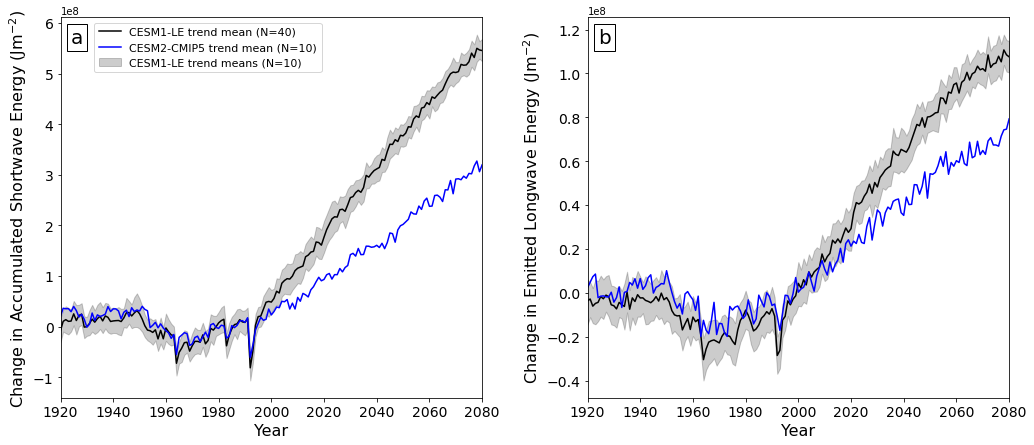

In [78]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
fig.subplots_adjust(wspace=0.25)

var = 'SW_ACC_TOA'
var2 = 'LW_EMM_TOA'
# var2 = 'FLUT'
# month = 10

_month_cesm1    = (cesm1le_tseries_reorg[var]    - cesm1le_pic_reorg[var].mean(dim='year'))#.sel(month=slice(8,11)).mean(dim='month')
_month_cesm2    = (cesm2cmip5_tseries_reorg[var] - cesm2cmip5_pic_reorg[var].mean(dim='year'))#.sel(month=slice(8,11)).mean(dim='month')
_month_cesm1_CI = (cesm1le_vars_bstrap10_ds[var] - cesm1le_pic_reorg[var].mean(dim='year'))#.sel(month=slice(8,11)).mean(dim='month')

_month_cesm1_var2    = (cesm1le_tseries_reorg[var2]    - cesm1le_pic_reorg[var2].mean(dim='year'))
_month_cesm2_var2    = (cesm2cmip5_tseries_reorg[var2] - cesm2cmip5_pic_reorg[var2].mean(dim='year'))
_month_cesm1_CI_var2 = (cesm1le_vars_bstrap10_ds[var2] - cesm1le_pic_reorg[var2].mean(dim='year'))

# _month_cesm1_var2    = (cesm1le_tseries_reorg[var2]    - cesm1le_pic_reorg[var2].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')
# _month_cesm2_var2    = (cesm2cmip5_tseries_reorg[var2] - cesm2cmip5_pic_reorg[var2].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')
# _month_cesm1_CI_var2 = (cesm1le_vars_bstrap10_ds[var2] - cesm1le_pic_reorg[var2].mean(dim='year')).sel(month=slice(8,11)).mean(dim='month')

# Plot melt season accumulated shortwave energy in the first panel
axs[0].plot(_month_cesm1['year'],_month_cesm1.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

axs[0].plot(_month_cesm2['year'],_month_cesm2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

axs[0].fill_between(x=_month_cesm1_CI.year,
                 y1=_month_cesm1_CI.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )

# Plot August-November emitted longwave energy in the second panel
axs[1].plot(_month_cesm1_var2['year'],_month_cesm1_var2.mean(dim='ens'),
        color='black',
        label='CESM1-LE trend mean (N=40)',
        )

axs[1].plot(_month_cesm2_var2['year'],_month_cesm2_var2.mean(dim='ens'),
        color='blue',
        label='CESM2-CMIP5 trend mean (N=10)',
        )

axs[1].fill_between(x=_month_cesm1_CI_var2.year,
                 y1=_month_cesm1_CI_var2.sel(bound=2.5,method='nearest'),
                 y2=_month_cesm1_CI_var2.sel(bound=97.5,method='nearest'),
                 color='black',
                 alpha=0.2,
                 label='CESM1-LE trend means (N=10)',
                )


# label panel 1
axs[0].set_ylabel('Change in Accumulated Shortwave Energy (Jm$^{-2}$)',fontsize=16)
axs[0].set_xlabel('Year',fontsize=16)
axs[0].tick_params(labelsize=14)
axs[0].set_xlim(1920,2080)


# label panel 2
axs[1].set_ylabel('Change in Emitted Longwave Energy (Jm$^{-2}$)',fontsize=16)
axs[1].set_xlabel('Year',fontsize=16)
axs[1].tick_params(labelsize=14)
axs[1].set_xlim(1920,2080)

# axs[0].set_title('Accumulated TOA Shortwave Energy (August-November, 1920-2080)',fontsize=16)
    
axs[0].legend(loc=(0.08,0.855),fontsize=11)
# axs[0].legend(loc=(0.47,0.01),fontsize=11)

props = dict(facecolor='white', alpha=1)

axs[0].text(1924,5.6e8,'a',fontsize=20,bbox=props)
axs[1].text(1924,1.14e8,'b',fontsize=20,bbox=props)

# fig.suptitle('Emitted Longwave Energy at the Surface (October-December, 1920-2080)',fontsize=18)

In [80]:
to_png(file=fig,filename='fig_CESM2_radiationchange',dpi=300,ext='pdf',bbox_inches='tight')